## TP Neural Networks

The architecture of this code is freely inspired from the torch and pytorch architectures, and some sample of code are re-used. It is however designed to be as concise as possible, not in any case for efficiency or flexibility (i.e. if you ever want to do Deep Learning out of this class, don't try to adapt this code, use an existing framework)

## 0. A simple MLP implementation

As always some useful imports:

In [1]:
import numpy as np 
# this is the key library for manipulating arrays. Use the online ressources! http://www.numpy.org/

import matplotlib.pyplot as plt 
# used to read images, display and plot http://matplotlib.org/api/pyplot_api.html . 
#You can also check this simple intro to using ipython notebook with images https://matplotlib.org/users/image_tutorial.html

%matplotlib inline 
# to display directly in the notebook

import scipy.ndimage as ndimage
# one of several python libraries for image procession

import scipy.io as sio
# usefull for loading mat files

import scipy.optimize as optimize
# usefull for optimization

plt.rcParams['image.cmap'] = 'gray' 
# by default, the grayscale images are displayed with the jet colormap: use grayscale instead

import gzip
#import cPickle # -> for python2
import pickle  # -> for python3
import os
import os.path
from six.moves import urllib

We will consider a Neural Network as a modular architecture, all layer and loss being a Module. We define the Linear, ReLU layers, necessary to implement a MLP, as well as a simple 2-layer MLP and the least square loss function, LeastSquareCriterion.

In [2]:
import math
import numpy as np

class Module(object):
    def __init__(self):
        self.gradInput=None 
        self.output=None
        
    def forward(self, *input):
        """Defines the computation performed at every call.
        Should be overriden by all subclasses.
        """
        raise NotImplementedError
        
    def backward(self, *input):
        """Defines the computation performed at every call.
        Should be overriden by all subclasses.
        """
        raise NotImplementedError
        
class LeastSquareCriterion(Module):
    """
    This implementation of the least square loss assumes that the data comes as a 2 dimensionnal array
    of size (batch_size,num_classes) and the labels as a vector of size (num_classes) 
    """
    def __init__(self, num_classes=10):
        super(LeastSquareCriterion, self).__init__()
        self.num_classes=num_classes
    
    def forward(self, x,labels):
        target=np.zeros([x.shape[0],self.num_classes])
        for i in range(x.shape[0]):
            target[i,labels[i]]=1
        self.output = np.sum((target-x)**2,axis=0)
        return np.sum(self.output)
    
    def backward(self, x, labels):
        self.gradInput=x
        for i in range(x.shape[0]):
            self.gradInput[i,labels[i]]=x[i,labels[i]]-1
        return self.gradInput
    

class Linear(Module):
    """
    The input is supposed to have two dimensions (batchSize,in_feature)
    """
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = math.sqrt(1. / (out_features* in_features))*np.random.randn(out_features, in_features)
        self.bias = np.zeros(out_features)
        self.gradWeight=None
        self.gradBias=None
        
    def forward(self, x):
        self.output= np.dot(x,self.weight.transpose())+np.repeat(self.bias.reshape([1,-1]),x.shape[0], axis=0)
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput=np.dot(gradOutput,self.weight)
        self.gradWeight=np.dot(gradOutput.transpose(),x)
        self.gradBias=np.sum(gradOutput, axis=0)
        return self.gradInput
    
    def gradientStep(self,lr):
        self.weight=self.weight-lr*self.gradWeight
        self.bias=self.bias-lr*self.gradBias
        

class ReLU(Module):
    
    def __init__(self, bias=True):
        super(ReLU, self).__init__()
        
    def forward(self, x):
        self.output=x.clip(0)
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput=(x>0)*gradOutput
        return self.gradInput
    
        

class MLP(Module):

    def __init__(self, num_classes=10):
        super(MLP, self).__init__()
        self.fc1 = Linear(784, 64)
        self.relu1 = ReLU()
        self.fc2 = Linear(64, 10)
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc2.backward(self.relu1.output,gradient)
        gradient = self.relu1.backward(self.fc1.output,gradient)
        gradient = self.fc1.backward(x,gradient)
        return gradient
    
    def gradientStep(self,lr):
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)
        return True

## 1. Training a neural network

To train a network, we will need data. Download the [MNIST data](http://deeplearning.net/data/mnist/mnist.pkl.gz) (~15Mo). I consists of 28x28 images (loaded as a 784 vector) and the associated label for training, validation and test sets. For this TP, you can focus on the training and validation sets.

5


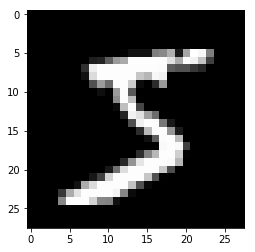

In [3]:
# Load the dataset
f = gzip.open('/Users/raphaelchekroun/DATA/mnist/mnist.pkl.gz', 'rb')
train_set, val_set, test_set = pickle.load(f, encoding='latin1') # python 3
f.close()
train_data=train_set[0]
train_labels=train_set[1]
val_data=val_set[0]
val_labels=val_set[1]
N_train=train_data.shape[1]
N_val=val_data.shape[1]
# check data makes sense
plt.imshow(train_data[0,:].reshape(28,28))
print(train_labels[0])

0/ Read and understand the code provided above

1/ Write a simple loop to train 50 iterations of the MLP defined in 0 with a learning rate 0.001 and batches of size 16.

In [4]:
def iteration(model, lsc, x, y, lr, training=True):
    out = model.forward(x)
    if training:
        grad_loss = lsc.backward(out, y)
        model.backward(x, grad_loss)
        model.gradientStep(lr)
    else:
        return lsc.forward(out,y),np.argmax(out,axis=1)==y

model = MLP()
lsc = LeastSquareCriterion()
lr = 0.001
batch_size = 16

for it in range(50):
    ind = np.random.choice(np.arange(len(train_data)), size=batch_size, replace=False)
    x, y = train_data[ind, :], train_labels[ind]
    iteration(model,lsc,x,y,lr,True)

In [5]:
# j'en ai fait une fonction avec comme argument un binaire qui seras utile dans la q3
model = MLP()
lsc = LeastSquareCriterion()
lr = 1e-3
batch_size = 16

def train_MLP(model, lsc, x, y, lr, training=True):
    LOSS,ACC = [],[]
    ind = np.random.randint(len(data), size=batch_size, replace = False)
    x,y = data[ind, :], train_labels[ind]
    out = model.forward(x)
    if training:
        grad_loss = lsc.backward(out, y)
        model.backward(x, grad_loss)
        model.gradientStep(lr)
        loss,acc = lsc.forward(out,y),np.argmax(out,axis=1)==y
        LOSS.append(loss)
        ACC.append(acc)

In [6]:
# Q.2 :

[20023 38748 27164 41325 23546 37901 30975 33796  6074 20500 40772  4714
 33998 30448  6271  4581]
Le nombre de la photo suivant censé être un 3


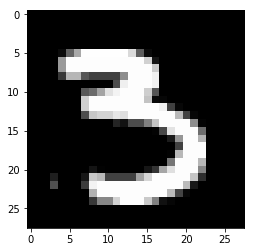

Le nombre de la photo suivant censé être un 5


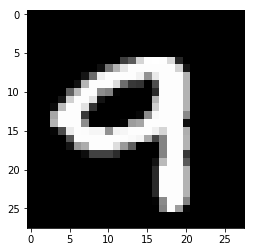

Le nombre de la photo suivant censé être un 8


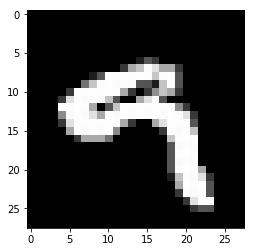

Le nombre de la photo suivant censé être un 8


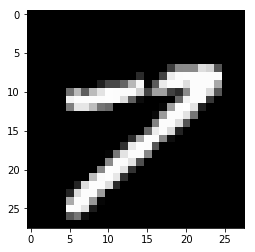

Le nombre de la photo suivant censé être un 7


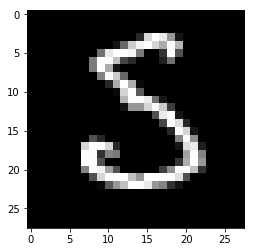

Le nombre de la photo suivant censé être un 2


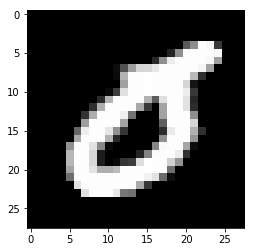

Le nombre de la photo suivant censé être un 0


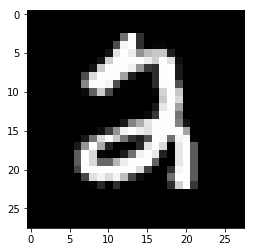

Le nombre de la photo suivant censé être un 2


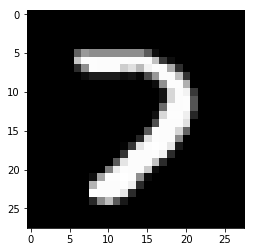

Le nombre de la photo suivant censé être un 9


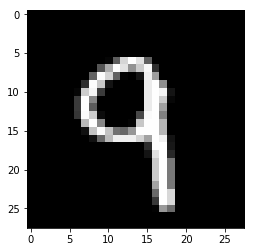

Le nombre de la photo suivant censé être un 0


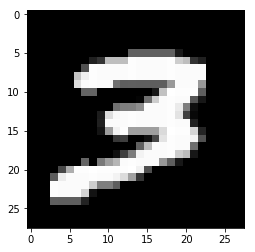

Le nombre de la photo suivant censé être un 9


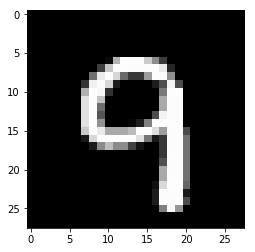

Le nombre de la photo suivant censé être un 0


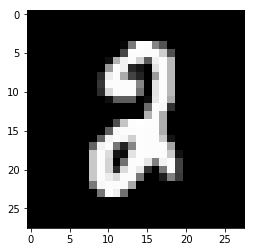

Le nombre de la photo suivant censé être un 9


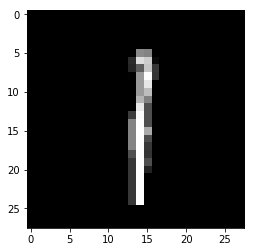

Le nombre de la photo suivant censé être un 0


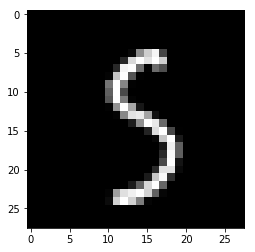

Le nombre de la photo suivant censé être un 6


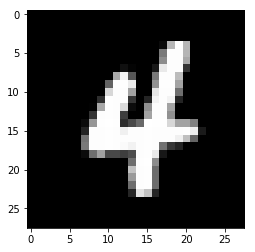

Le nombre de la photo suivant censé être un 2


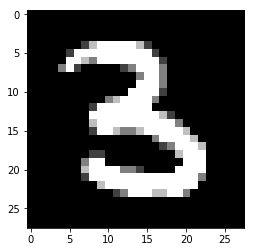

In [7]:
ind = np.random.choice(np.arange(len(train_data)), size=batch_size, replace=False)

print(ind)
for i,n in enumerate(ind):
    x,y = train_data[n,:].reshape(28,28), train_labels[n]
    print("Le nombre de la photo suivant censé être un",np.argmax(model.forward(train_data[n,:])))
    plt.imshow(x)
    plt.show()

3/ Plot the training and validation losses and accuracies during the training of question 1. (note: you don't have to test your network at every iteration, you can for example do it every 10 iterations)

In [8]:
# je refait la même chose mais dans une fonction, ce seras plus simple dans la suite...

def training(model, lsc, lr, indices):
    loss={}
    loss['train'],loss['validation']=[],[]
    
    acc={}
    acc['train'],acc['validation']=[],[]
    it=0
    for inds in zip(indices['train'],indices['validation']):
        it+=1
        for ind,train_val in zip(inds,['train','validation']):
            if train_val=='train':
                x,y = train_data[ind, :], train_labels[ind]
                iteration(model,lsc,x,y,lr,True)
            else:
                x,y = val_data[ind, :], val_labels[ind]
            if it%10==0: # je n'affiche pas tous les points, sinon on ne voit plus rien
                loss_tmp,juste = iteration(model,lsc,x,y,lr,False)
                loss[train_val].append(loss_tmp)
                acc[train_val].append(np.sum(juste)/len(juste))
    return loss, acc

In [9]:
model = MLP()
lsc = LeastSquareCriterion()
lr = 0.001
indices = {}

indices['train'] = np.random.choice(np.arange(len(train_data)), size=(50,batch_size), replace=False)
indices['validation'] = np.random.choice(np.arange(len(val_data)),size=(50,batch_size),replace=False)

loss,acc=training(model,lsc,lr,indices)

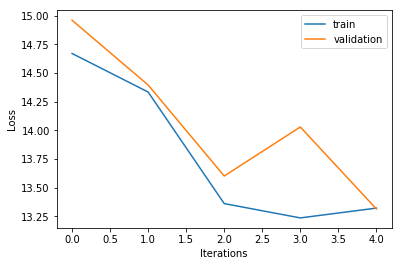

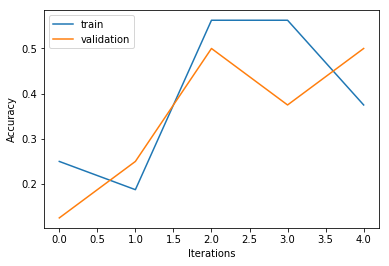

In [10]:
def afficher(dico,nom):
    for train_valid in ['train','validation']:
        plt.plot([i for i in range(len(dico[train_valid]))],dico[train_valid],label=train_valid)
        plt.xlabel("Iterations")
        plt.ylabel(nom)
        plt.legend()
    plt.show()
    
afficher(loss,"Loss")
afficher(acc,"Accuracy")

4/ Design a training procedure that optimize the training loss (decide for a learning rate, batch size...)

Pour un learning rate de 0.0 la training loss atteint la valeur finale 31.86671912217965


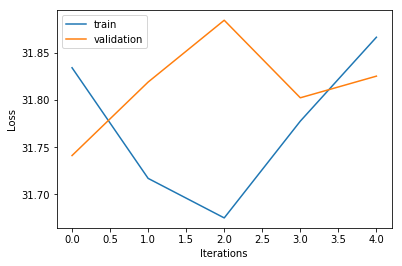

Pour un learning rate de 0.0002 la training loss atteint la valeur finale 28.45726922733021


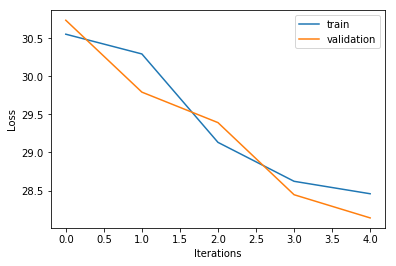

Pour un learning rate de 0.0004 la training loss atteint la valeur finale 26.986840270040105


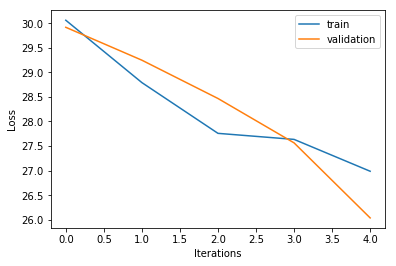

Pour un learning rate de 0.0006000000000000001 la training loss atteint la valeur finale 25.34252726245855


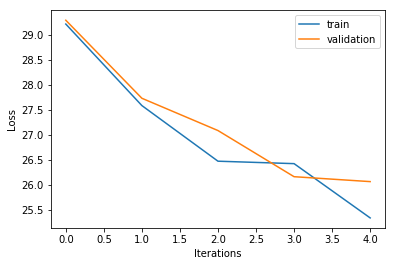

Pour un learning rate de 0.0008 la training loss atteint la valeur finale 23.904700041411353


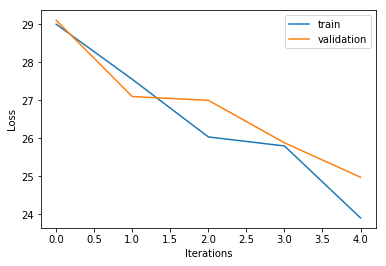

Pour un learning rate de 0.001 la training loss atteint la valeur finale 23.13875691082187


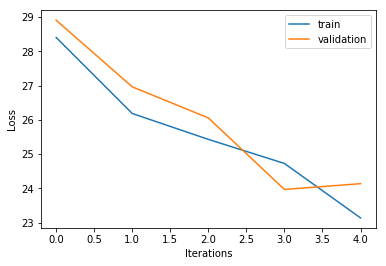

Pour un learning rate de 0.0012000000000000001 la training loss atteint la valeur finale 22.788906970428812


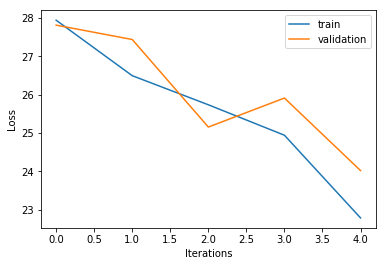

Pour un learning rate de 0.0014 la training loss atteint la valeur finale 22.015494834635064


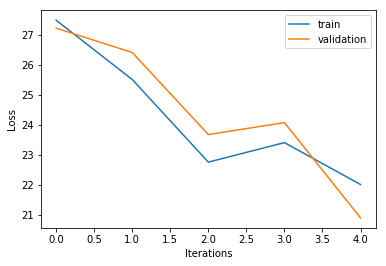

Pour un learning rate de 0.0016 la training loss atteint la valeur finale 19.420651358786408


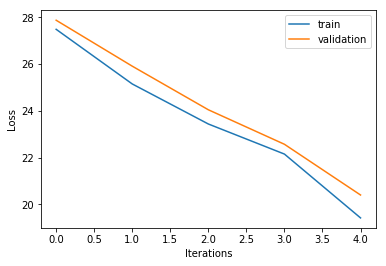

Pour un learning rate de 0.0018000000000000002 la training loss atteint la valeur finale 19.581208288927623


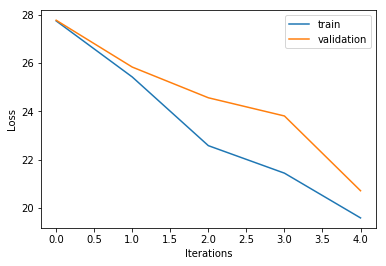

Pour un learning rate de 0.002 la training loss atteint la valeur finale 20.137503701778943


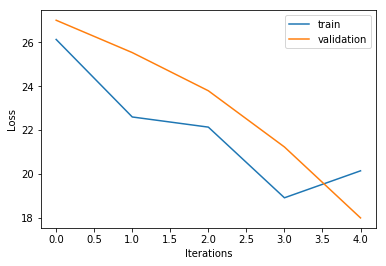

Pour un learning rate de 0.0022 la training loss atteint la valeur finale 16.231464755244986


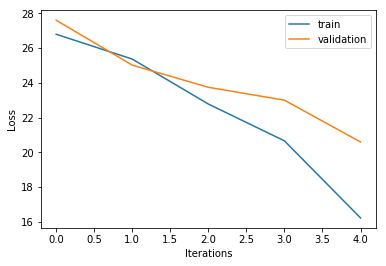

Pour un learning rate de 0.0024000000000000002 la training loss atteint la valeur finale 17.559461631548515


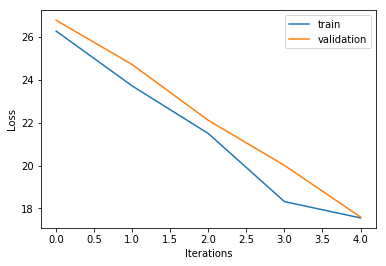

Pour un learning rate de 0.0026000000000000003 la training loss atteint la valeur finale 16.08606403469009


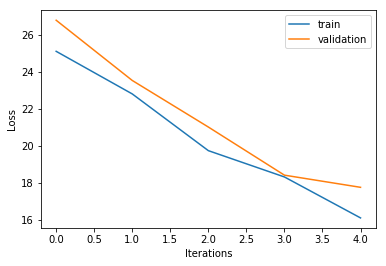

Pour un learning rate de 0.0028 la training loss atteint la valeur finale 17.029493076962257


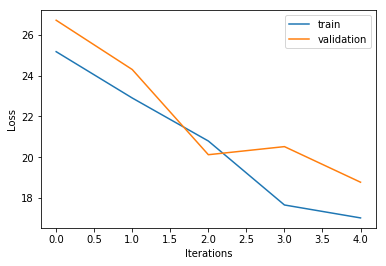

Pour un learning rate de 0.003 la training loss atteint la valeur finale 15.482456257163383


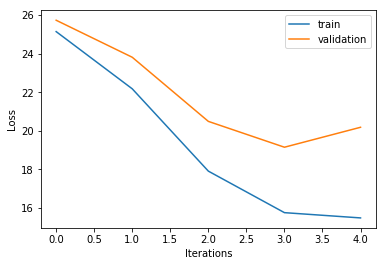

Pour un learning rate de 0.0032 la training loss atteint la valeur finale 16.322018127214086


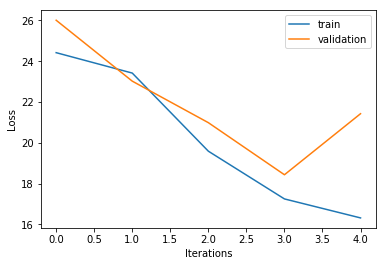

Pour un learning rate de 0.0034000000000000002 la training loss atteint la valeur finale 15.47081918044212


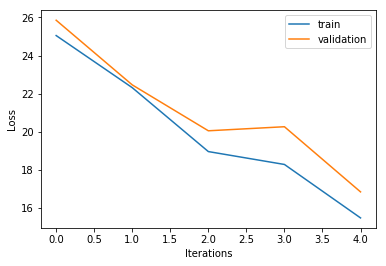

Pour un learning rate de 0.0036000000000000003 la training loss atteint la valeur finale 16.456218919008105


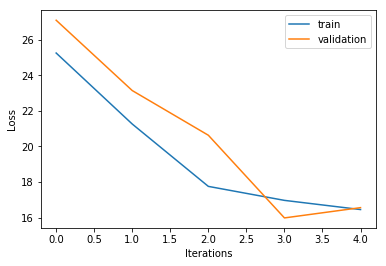

Pour un learning rate de 0.0038 la training loss atteint la valeur finale 15.219457547322527


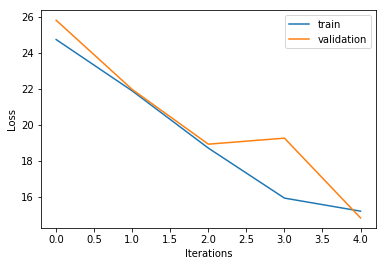

Pour un learning rate de 0.004 la training loss atteint la valeur finale 15.385529465137353


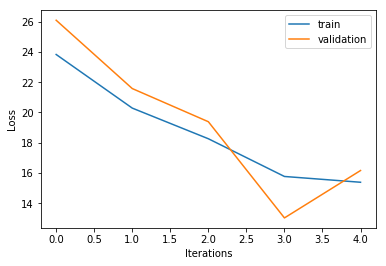

Pour un learning rate de 0.004200000000000001 la training loss atteint la valeur finale 13.717776337820535


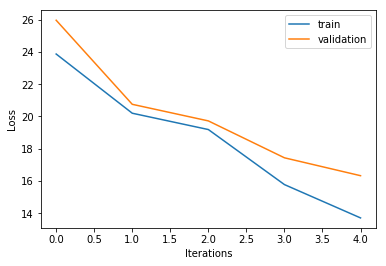

Pour un learning rate de 0.0044 la training loss atteint la valeur finale 14.021513230717957


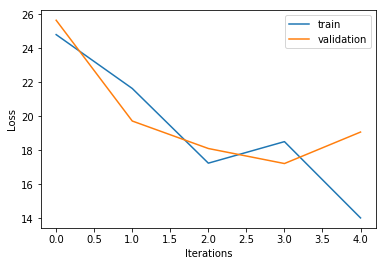

Pour un learning rate de 0.0046 la training loss atteint la valeur finale 16.514009219575595


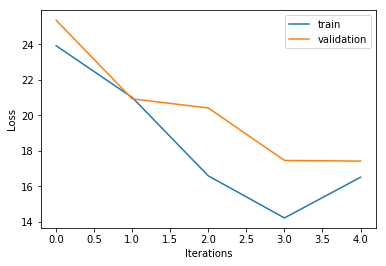

Pour un learning rate de 0.0048000000000000004 la training loss atteint la valeur finale 15.713848606944147


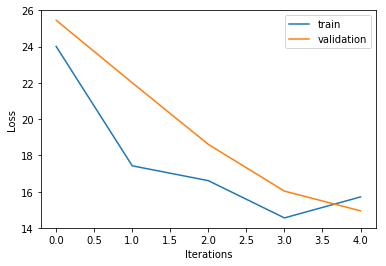

Pour un learning rate de 0.005 la training loss atteint la valeur finale 12.486762308034507


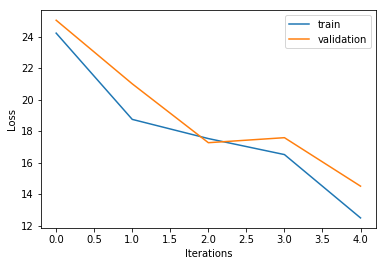

Pour un learning rate de 0.005200000000000001 la training loss atteint la valeur finale 13.536049391014775


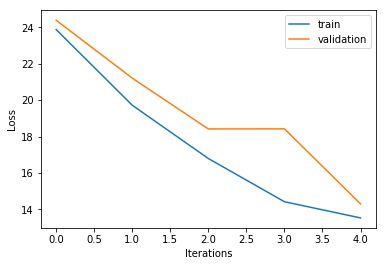

Pour un learning rate de 0.0054 la training loss atteint la valeur finale 13.721610641233354


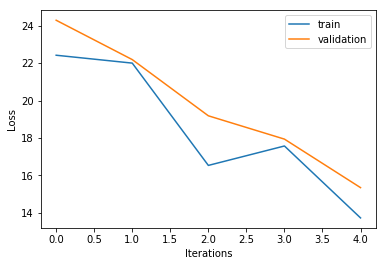

Pour un learning rate de 0.0056 la training loss atteint la valeur finale 15.049385189807083


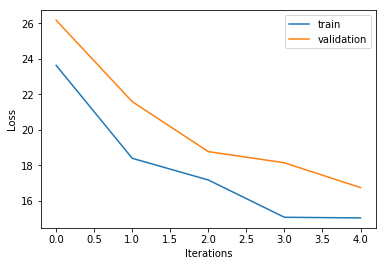

Pour un learning rate de 0.0058000000000000005 la training loss atteint la valeur finale 13.189906658717437


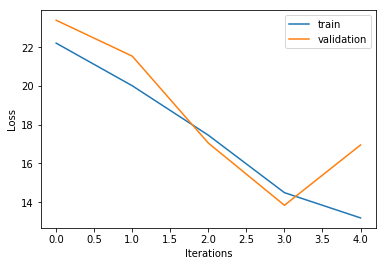

Pour un learning rate de 0.006 la training loss atteint la valeur finale 11.366839162636957


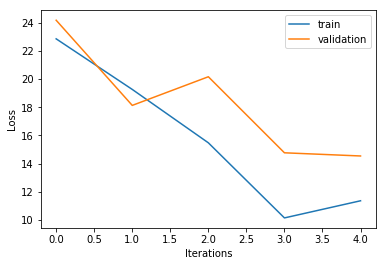

Pour un learning rate de 0.006200000000000001 la training loss atteint la valeur finale 12.514712802913106


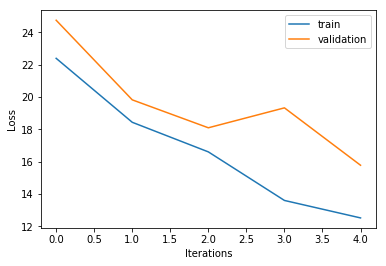

Pour un learning rate de 0.0064 la training loss atteint la valeur finale 14.49946796705995


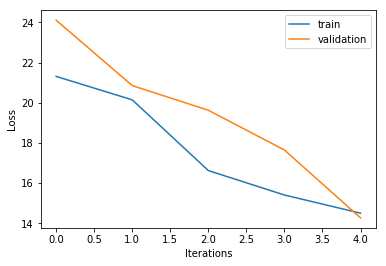

Pour un learning rate de 0.0066 la training loss atteint la valeur finale 10.834150886553108


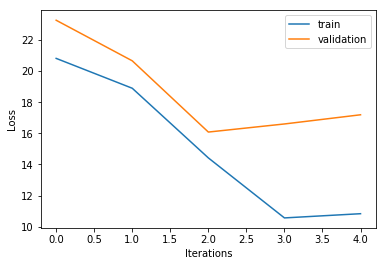

Pour un learning rate de 0.0068000000000000005 la training loss atteint la valeur finale 12.54965825764335


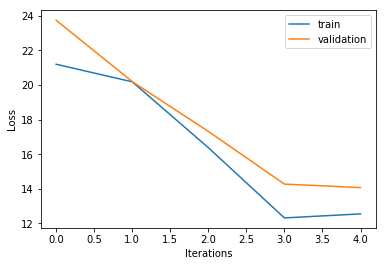

Pour un learning rate de 0.007 la training loss atteint la valeur finale 13.033300632051596


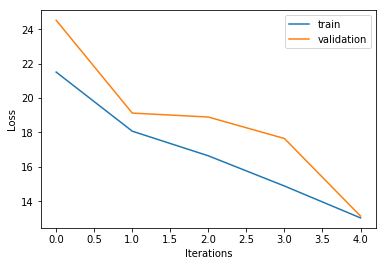

Pour un learning rate de 0.007200000000000001 la training loss atteint la valeur finale 14.090543139132185


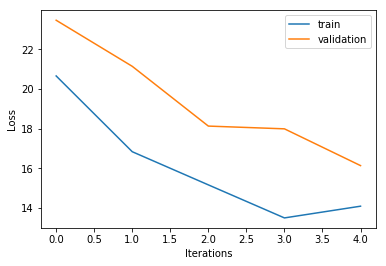

Pour un learning rate de 0.0074 la training loss atteint la valeur finale 14.162634843276535


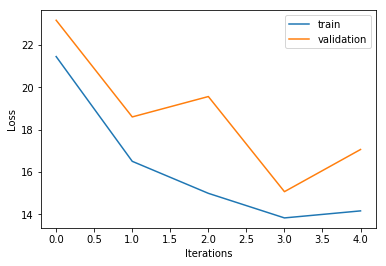

Pour un learning rate de 0.0076 la training loss atteint la valeur finale 10.04301685386646


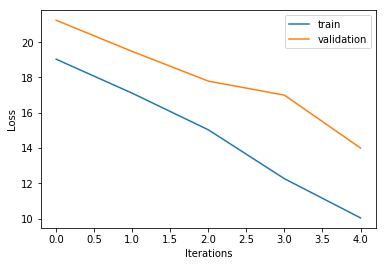

Pour un learning rate de 0.0078000000000000005 la training loss atteint la valeur finale 11.444375523234193


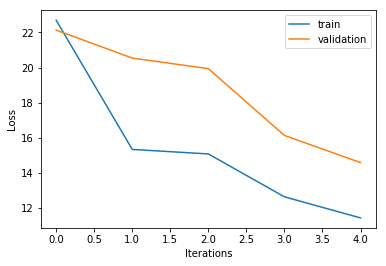

Pour un learning rate de 0.008 la training loss atteint la valeur finale 13.135163336091297


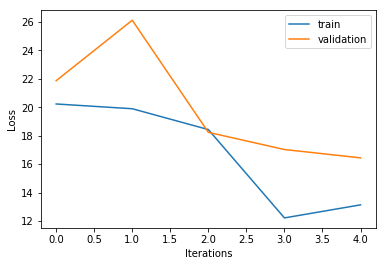

Pour un learning rate de 0.0082 la training loss atteint la valeur finale 9.748957827345041


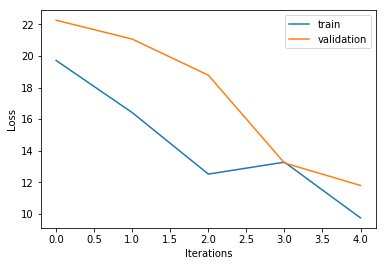

Pour un learning rate de 0.008400000000000001 la training loss atteint la valeur finale 13.292965997567325


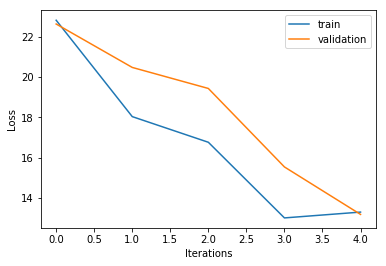

Pour un learning rate de 0.0086 la training loss atteint la valeur finale 9.328862174213574


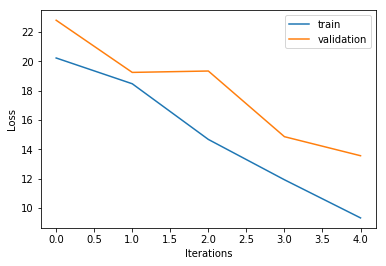

Pour un learning rate de 0.0088 la training loss atteint la valeur finale 12.989185038912096


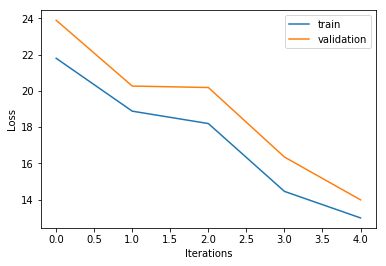

Pour un learning rate de 0.009000000000000001 la training loss atteint la valeur finale 10.60481144769156


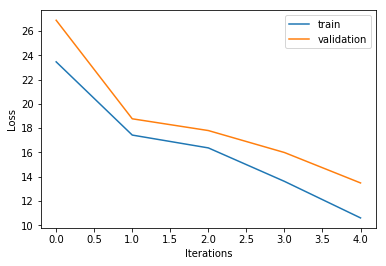

Pour un learning rate de 0.0092 la training loss atteint la valeur finale 11.916138567221223


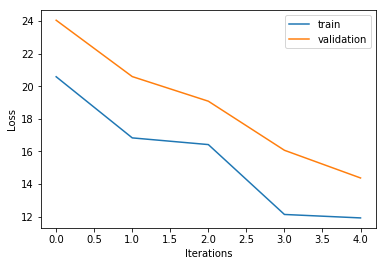

Pour un learning rate de 0.0094 la training loss atteint la valeur finale 12.49496642004902


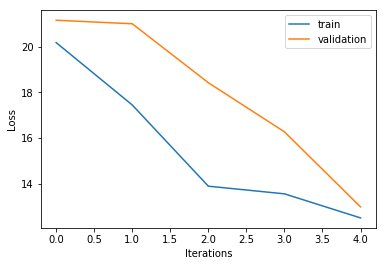

Pour un learning rate de 0.009600000000000001 la training loss atteint la valeur finale 12.508217636592736


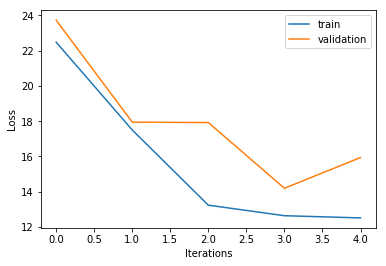

Pour un learning rate de 0.0098 la training loss atteint la valeur finale 13.431234577144282


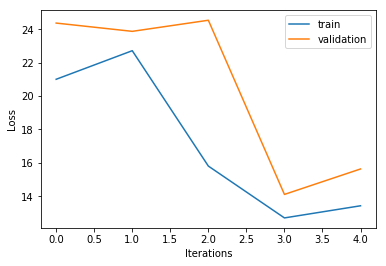

Pour un learning rate de 0.01 la training loss atteint la valeur finale 11.924284050123681


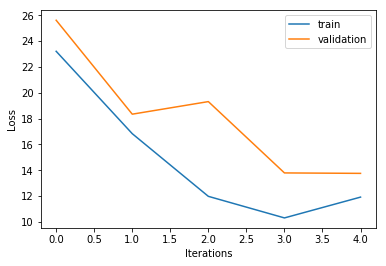

Pour un learning rate de 0.0102 la training loss atteint la valeur finale 9.970788815387087


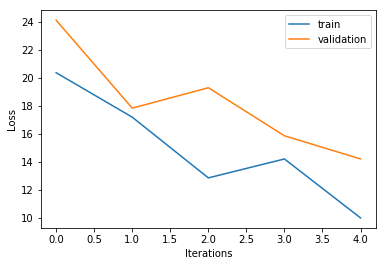

Pour un learning rate de 0.010400000000000001 la training loss atteint la valeur finale 11.574423647763412


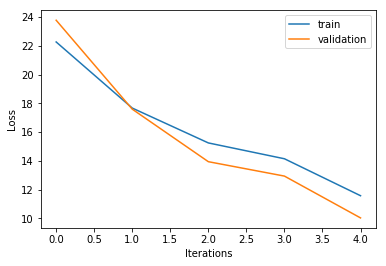

Pour un learning rate de 0.0106 la training loss atteint la valeur finale 12.226156950073504


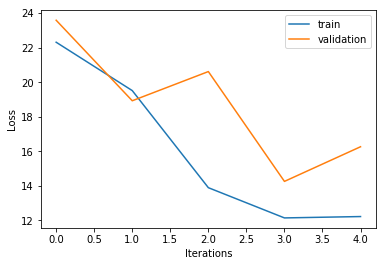

Pour un learning rate de 0.0108 la training loss atteint la valeur finale 14.628962939665032


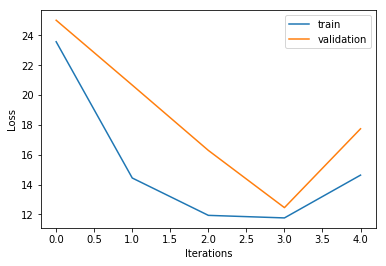

Pour un learning rate de 0.011000000000000001 la training loss atteint la valeur finale 11.184054566899924


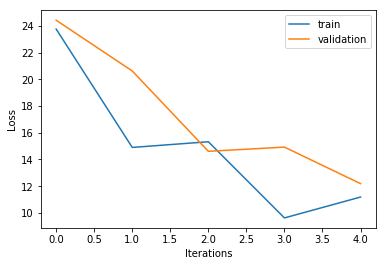

Pour un learning rate de 0.0112 la training loss atteint la valeur finale 10.141695334490729


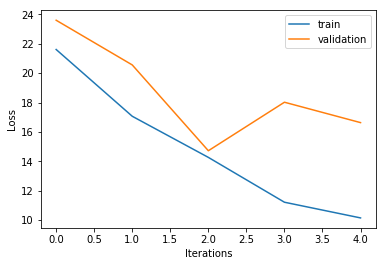

Pour un learning rate de 0.0114 la training loss atteint la valeur finale 7.529272109929321


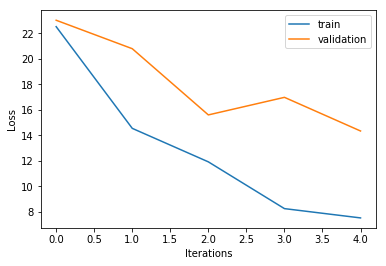

Pour un learning rate de 0.011600000000000001 la training loss atteint la valeur finale 11.238867119577245


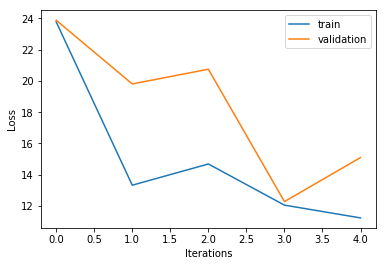

Pour un learning rate de 0.0118 la training loss atteint la valeur finale 14.47101877729148


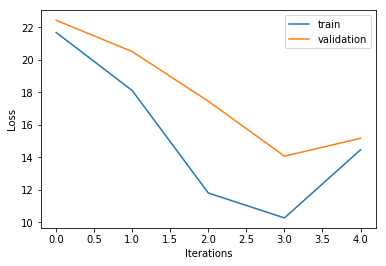

Pour un learning rate de 0.012 la training loss atteint la valeur finale 13.019878766231574


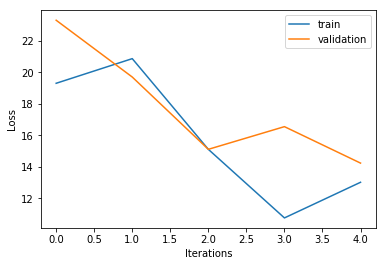

Pour un learning rate de 0.0122 la training loss atteint la valeur finale 14.134328521636036


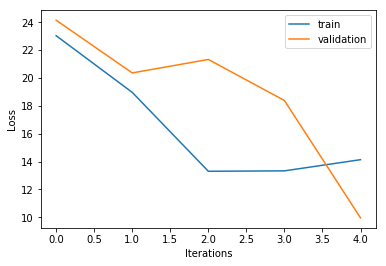

Pour un learning rate de 0.012400000000000001 la training loss atteint la valeur finale 9.705974857524286


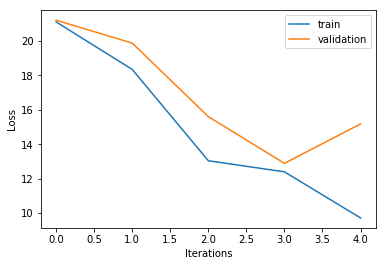

Pour un learning rate de 0.0126 la training loss atteint la valeur finale 8.36044922073145


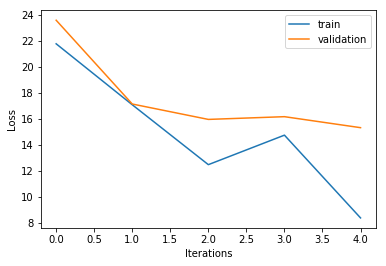

Pour un learning rate de 0.0128 la training loss atteint la valeur finale 10.46748226691058


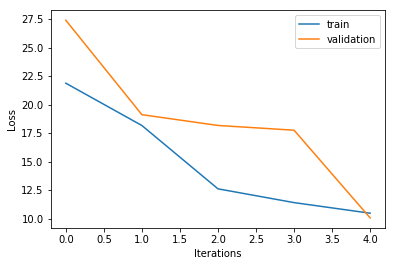

Pour un learning rate de 0.013000000000000001 la training loss atteint la valeur finale 11.13408849419802


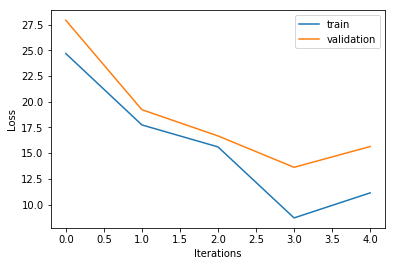

Pour un learning rate de 0.0132 la training loss atteint la valeur finale 9.28268531556971


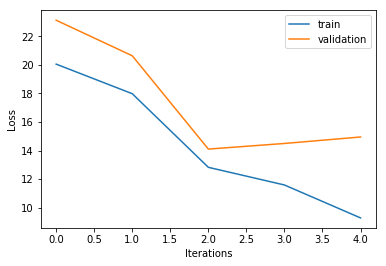

Pour un learning rate de 0.0134 la training loss atteint la valeur finale 9.729376430136854


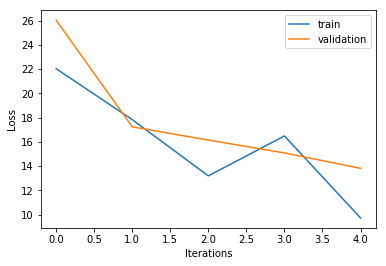

Pour un learning rate de 0.013600000000000001 la training loss atteint la valeur finale 7.584961914881857


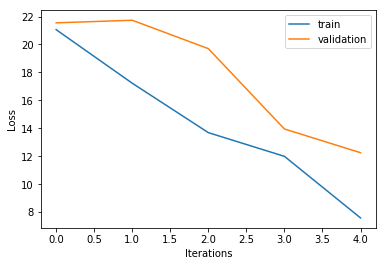

Pour un learning rate de 0.013800000000000002 la training loss atteint la valeur finale 9.853982276395438


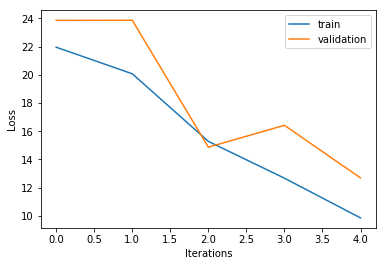

Pour un learning rate de 0.014 la training loss atteint la valeur finale 9.100643388724166


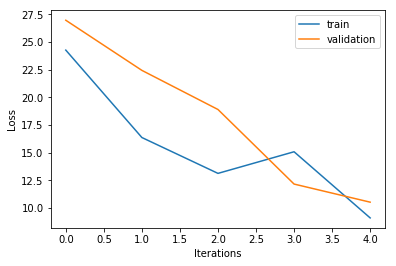

Pour un learning rate de 0.0142 la training loss atteint la valeur finale 8.185376636270062


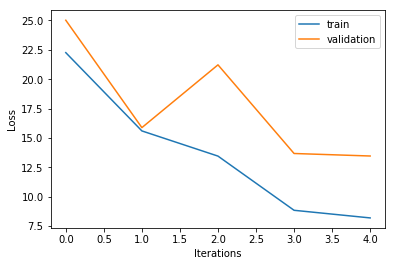

Pour un learning rate de 0.014400000000000001 la training loss atteint la valeur finale 12.415844896275948


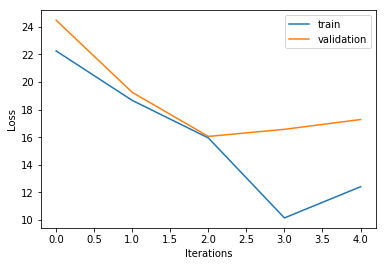

Pour un learning rate de 0.0146 la training loss atteint la valeur finale 12.216043097869802


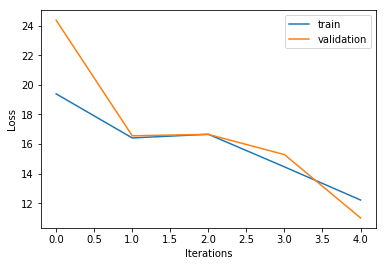

Pour un learning rate de 0.0148 la training loss atteint la valeur finale 8.800955669290026


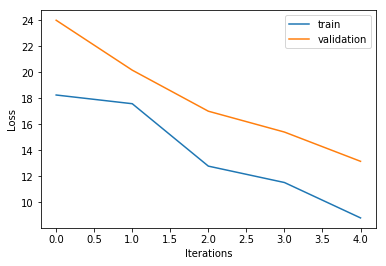

Pour un learning rate de 0.015000000000000001 la training loss atteint la valeur finale 10.165858154152872


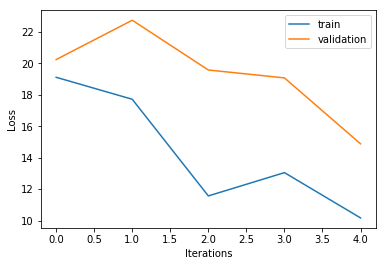

Pour un learning rate de 0.0152 la training loss atteint la valeur finale 15.167062395955373


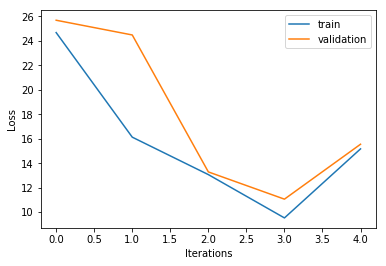

Pour un learning rate de 0.0154 la training loss atteint la valeur finale 12.574353106380705


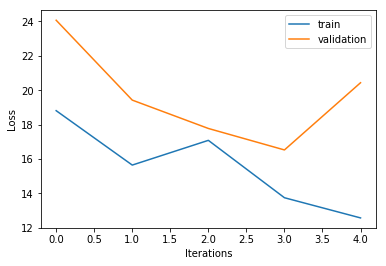

Pour un learning rate de 0.015600000000000001 la training loss atteint la valeur finale 11.005879053744898


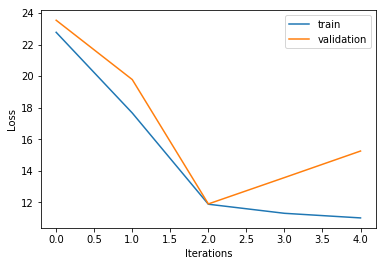

Pour un learning rate de 0.0158 la training loss atteint la valeur finale 12.395202088230292


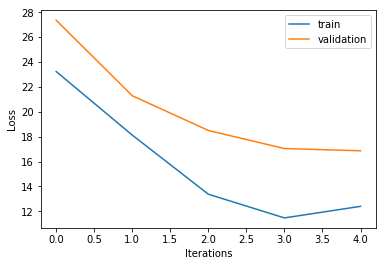

Pour un learning rate de 0.016 la training loss atteint la valeur finale 10.222946855094516


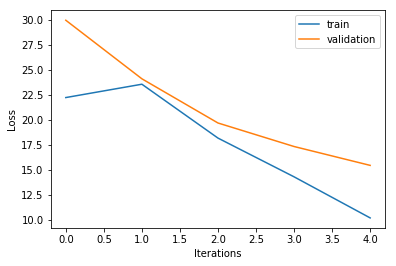

Pour un learning rate de 0.0162 la training loss atteint la valeur finale 13.330612063155142


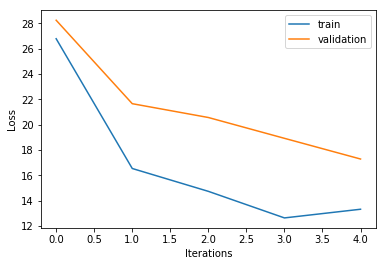

Pour un learning rate de 0.0164 la training loss atteint la valeur finale 10.77220730742141


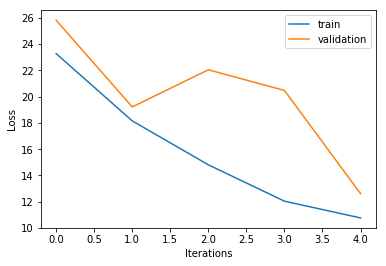

Pour un learning rate de 0.0166 la training loss atteint la valeur finale 11.158045159946283


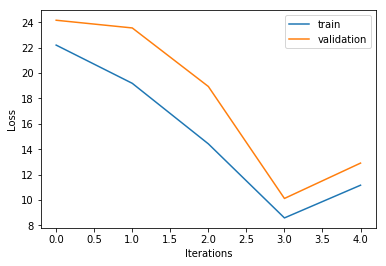

Pour un learning rate de 0.016800000000000002 la training loss atteint la valeur finale 12.321141187877034


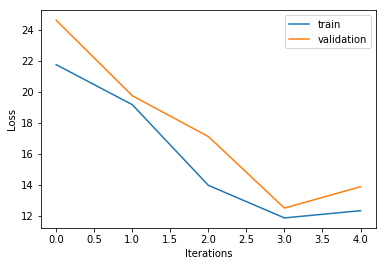

Pour un learning rate de 0.017 la training loss atteint la valeur finale 10.758481993097911


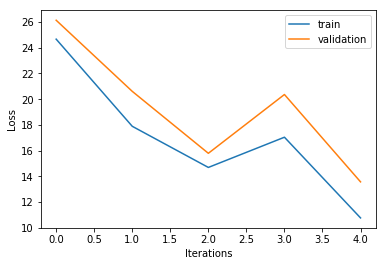

Pour un learning rate de 0.0172 la training loss atteint la valeur finale 11.924310776199391


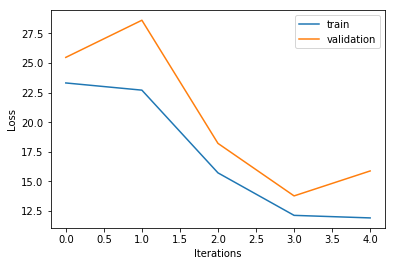

Pour un learning rate de 0.017400000000000002 la training loss atteint la valeur finale 7.808856021490843


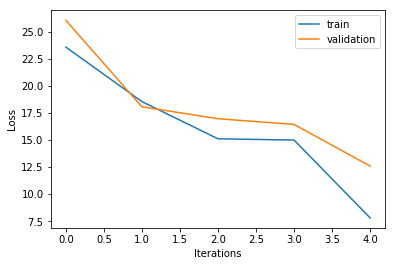

Pour un learning rate de 0.0176 la training loss atteint la valeur finale 13.945947910227435


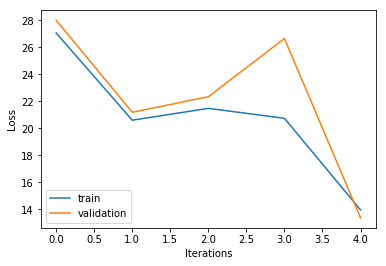

Pour un learning rate de 0.0178 la training loss atteint la valeur finale 10.915227119538416


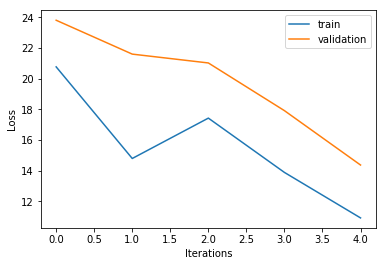

Pour un learning rate de 0.018000000000000002 la training loss atteint la valeur finale 12.1169435778806


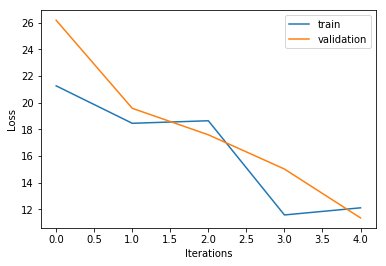

Pour un learning rate de 0.0182 la training loss atteint la valeur finale 8.654682654615167


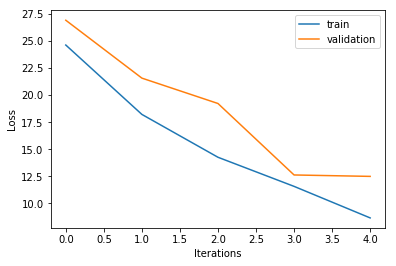

Pour un learning rate de 0.0184 la training loss atteint la valeur finale 14.531098252743979


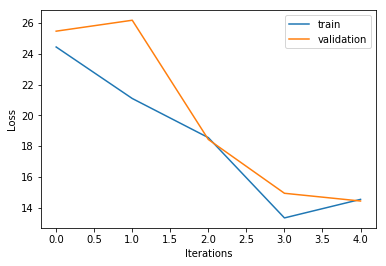

Pour un learning rate de 0.018600000000000002 la training loss atteint la valeur finale 15.289602082241302


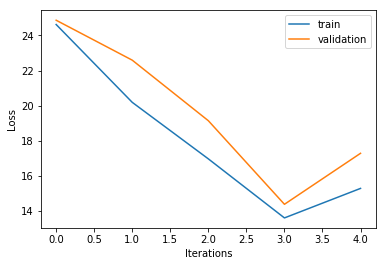

Pour un learning rate de 0.0188 la training loss atteint la valeur finale 10.581718514715565


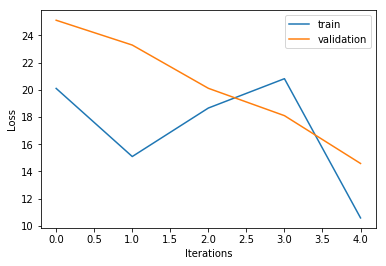

Pour un learning rate de 0.019 la training loss atteint la valeur finale 13.55988477092106


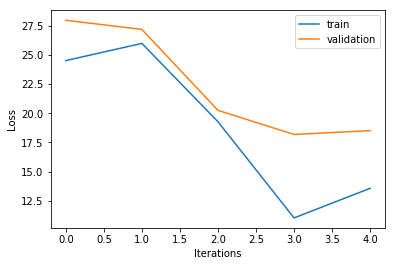

Pour un learning rate de 0.019200000000000002 la training loss atteint la valeur finale 13.390683859729874


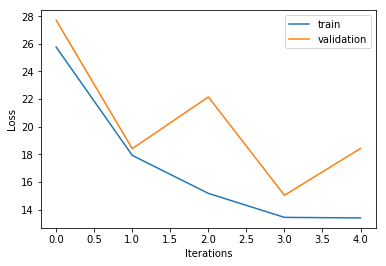

Pour un learning rate de 0.0194 la training loss atteint la valeur finale 14.311563852186666


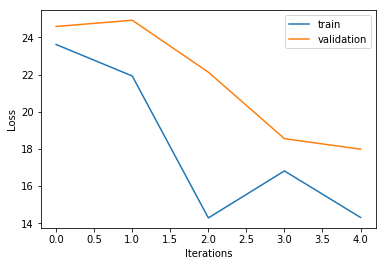

Pour un learning rate de 0.0196 la training loss atteint la valeur finale 12.619419613075259


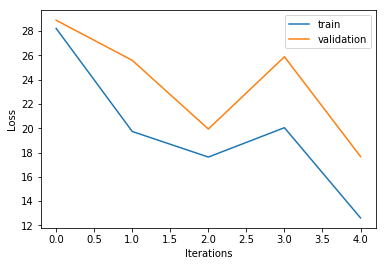

Pour un learning rate de 0.0198 la training loss atteint la valeur finale 15.537369173998938


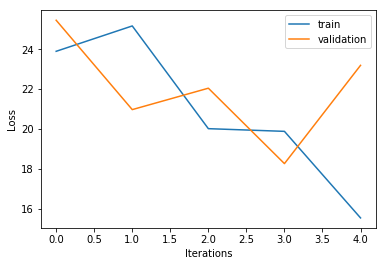

Pour un learning rate de 0.02 la training loss atteint la valeur finale 10.668469745419195


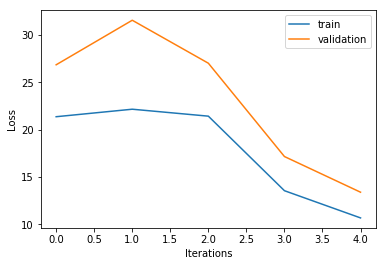

Pour un learning rate de 0.020200000000000003 la training loss atteint la valeur finale 14.746330438562499


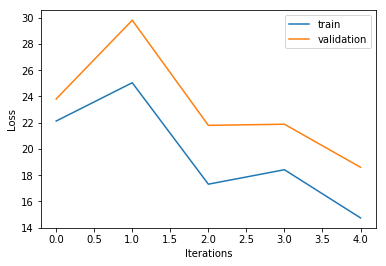

Pour un learning rate de 0.0204 la training loss atteint la valeur finale 12.50736609390713


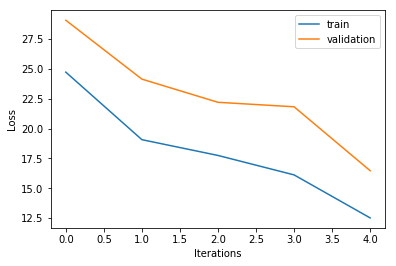

Pour un learning rate de 0.0206 la training loss atteint la valeur finale 15.79192677203859


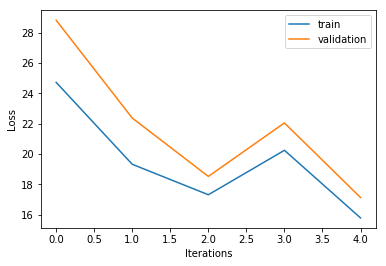

Pour un learning rate de 0.020800000000000003 la training loss atteint la valeur finale 27.75218096201933


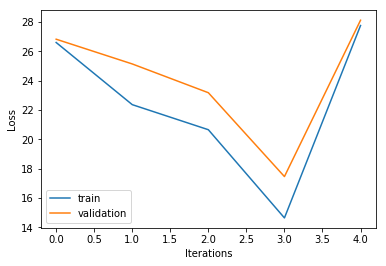

Pour un learning rate de 0.021 la training loss atteint la valeur finale 15.325857300081665


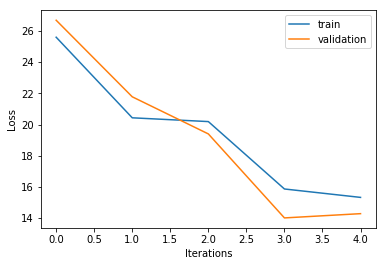

Pour un learning rate de 0.0212 la training loss atteint la valeur finale 19.04117503416776


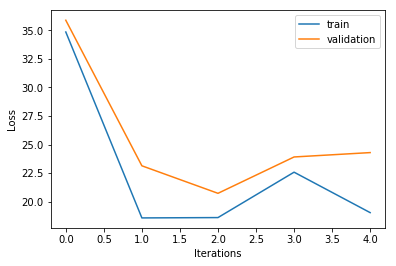

Pour un learning rate de 0.021400000000000002 la training loss atteint la valeur finale 13.342964032935278


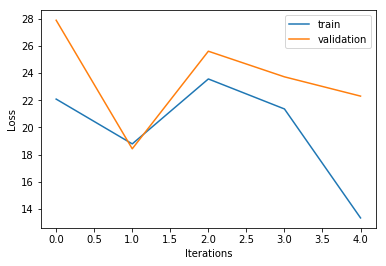

Pour un learning rate de 0.0216 la training loss atteint la valeur finale 19.832374470228388


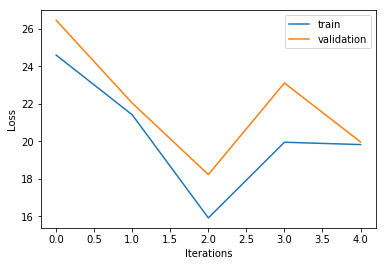

Pour un learning rate de 0.0218 la training loss atteint la valeur finale 16.480672896875056


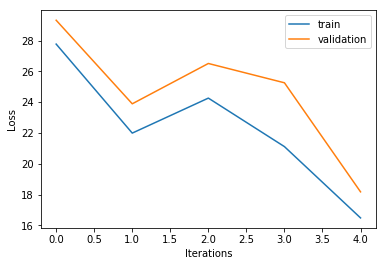

Pour un learning rate de 0.022000000000000002 la training loss atteint la valeur finale 11.561133916628787


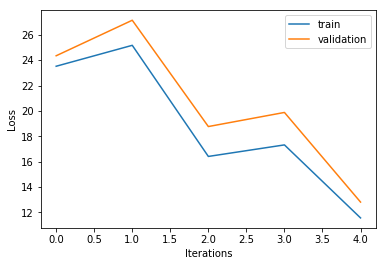

Pour un learning rate de 0.0222 la training loss atteint la valeur finale 14.939623592183812


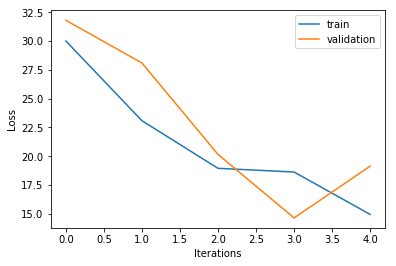

Pour un learning rate de 0.0224 la training loss atteint la valeur finale 16.68336371546026


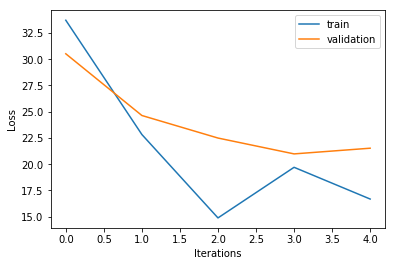

Pour un learning rate de 0.022600000000000002 la training loss atteint la valeur finale 21.15585926217891


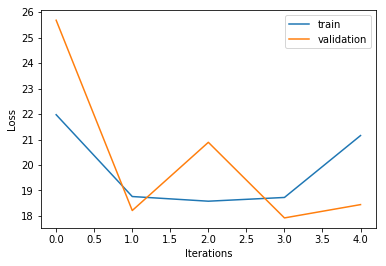

Pour un learning rate de 0.0228 la training loss atteint la valeur finale 15.322222034588439


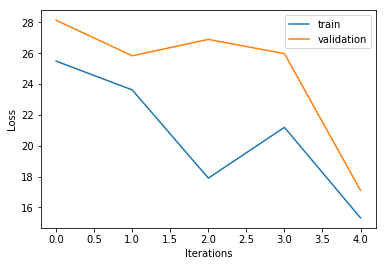

Pour un learning rate de 0.023 la training loss atteint la valeur finale 24.16488923016748


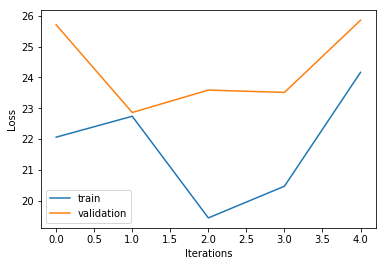

Pour un learning rate de 0.023200000000000002 la training loss atteint la valeur finale 14.386815570131532


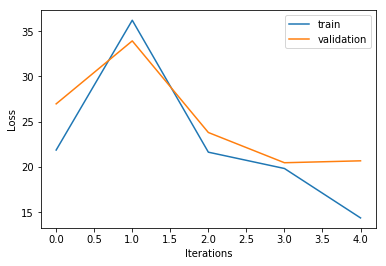

Pour un learning rate de 0.0234 la training loss atteint la valeur finale 13.753684400826318


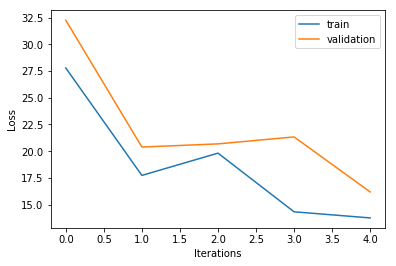

Pour un learning rate de 0.0236 la training loss atteint la valeur finale 19.0878543036426


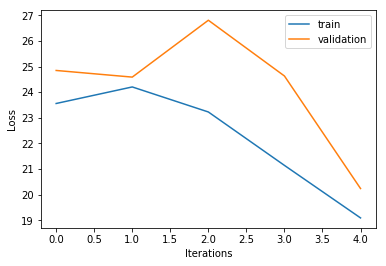

Pour un learning rate de 0.0238 la training loss atteint la valeur finale 23.030542930963037


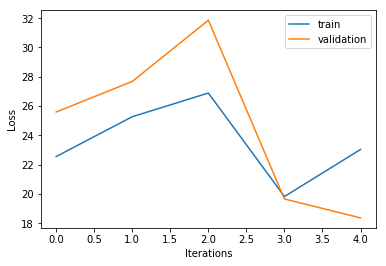

Pour un learning rate de 0.024 la training loss atteint la valeur finale 17.4703926746035


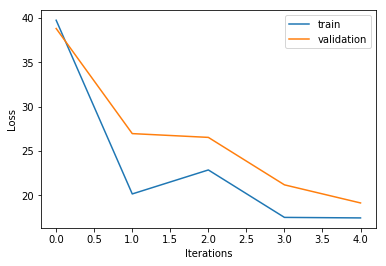

Pour un learning rate de 0.024200000000000003 la training loss atteint la valeur finale 23.342690706088863


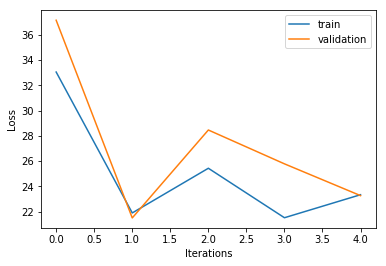

Pour un learning rate de 0.0244 la training loss atteint la valeur finale 26.676988131561316


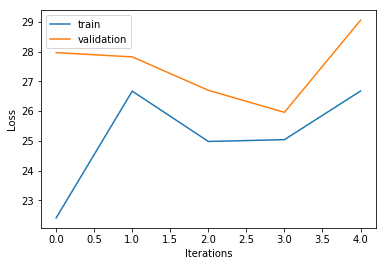

Pour un learning rate de 0.0246 la training loss atteint la valeur finale 22.820090162531603


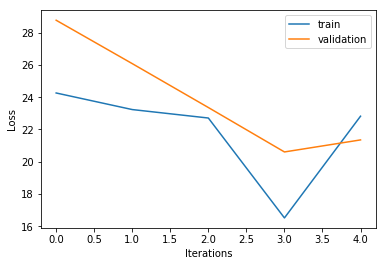

Pour un learning rate de 0.024800000000000003 la training loss atteint la valeur finale 22.677051600092387


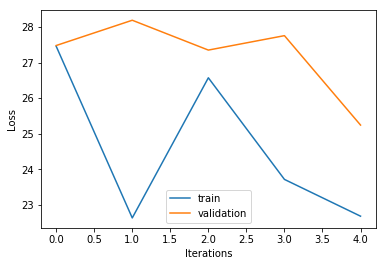

Pour un learning rate de 0.025 la training loss atteint la valeur finale 25.03233966295418


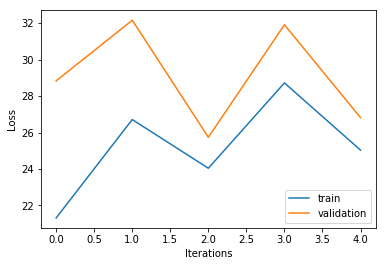

Pour un learning rate de 0.0252 la training loss atteint la valeur finale 17.233005822136537


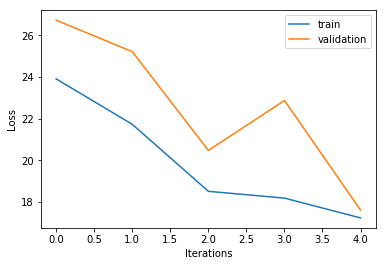

Pour un learning rate de 0.025400000000000002 la training loss atteint la valeur finale 16.78682179714787


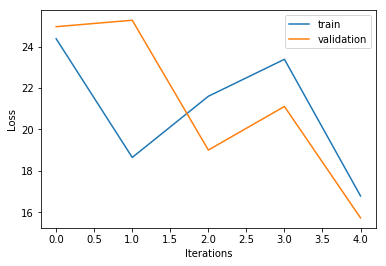

Pour un learning rate de 0.0256 la training loss atteint la valeur finale 24.186619789438595


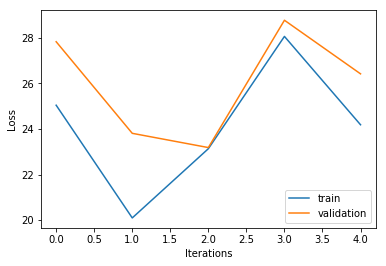

Pour un learning rate de 0.0258 la training loss atteint la valeur finale 20.025349059412623


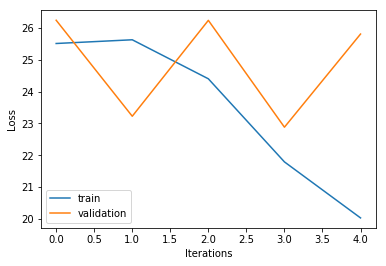

Pour un learning rate de 0.026000000000000002 la training loss atteint la valeur finale 23.604966942291814


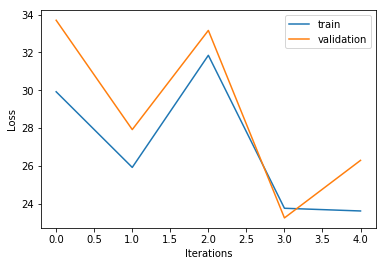

Pour un learning rate de 0.0262 la training loss atteint la valeur finale 22.37311894823694


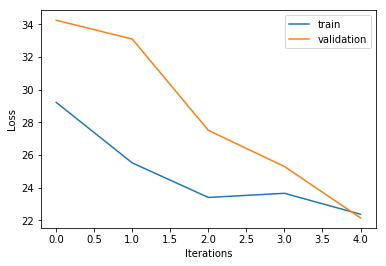

Pour un learning rate de 0.0264 la training loss atteint la valeur finale 22.27163231624729


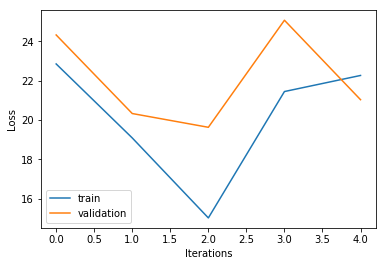

Pour un learning rate de 0.026600000000000002 la training loss atteint la valeur finale 25.05213937888228


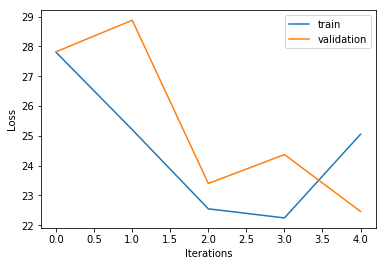

Pour un learning rate de 0.0268 la training loss atteint la valeur finale 29.648342382532306


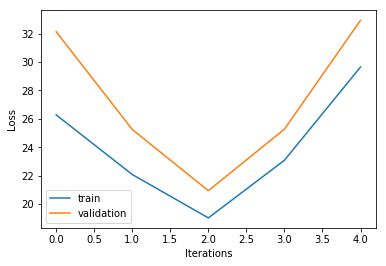

Pour un learning rate de 0.027 la training loss atteint la valeur finale 22.60860070477344


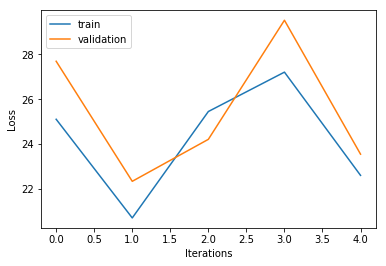

Pour un learning rate de 0.027200000000000002 la training loss atteint la valeur finale 25.480075516999985


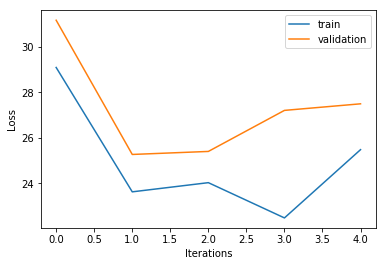

Pour un learning rate de 0.0274 la training loss atteint la valeur finale 24.549051544705044


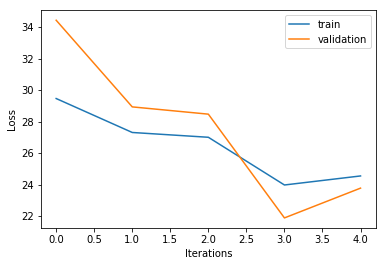

Pour un learning rate de 0.027600000000000003 la training loss atteint la valeur finale 23.040540346472156


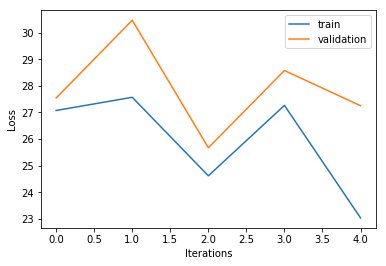

Pour un learning rate de 0.027800000000000002 la training loss atteint la valeur finale 24.861982450260722


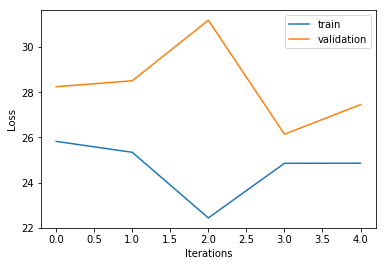

Pour un learning rate de 0.028 la training loss atteint la valeur finale 25.912018662293903


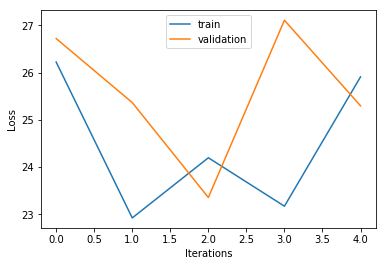

Pour un learning rate de 0.028200000000000003 la training loss atteint la valeur finale 27.762215638275762


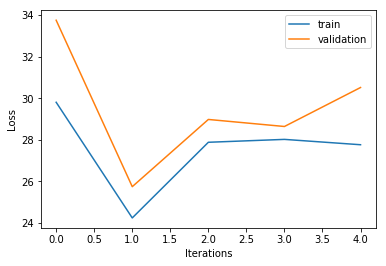

Pour un learning rate de 0.0284 la training loss atteint la valeur finale 22.095167886161516


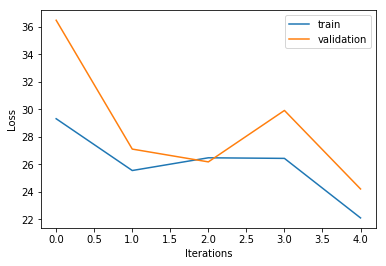

Pour un learning rate de 0.0286 la training loss atteint la valeur finale 26.72821646012151


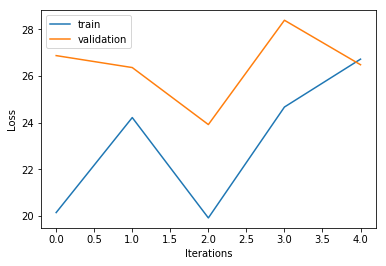

Pour un learning rate de 0.028800000000000003 la training loss atteint la valeur finale 25.047641642293673


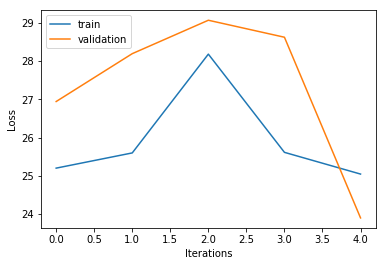

Pour un learning rate de 0.029 la training loss atteint la valeur finale 21.609858647923623


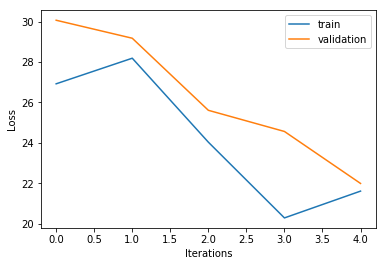

Pour un learning rate de 0.0292 la training loss atteint la valeur finale 25.694584908607002


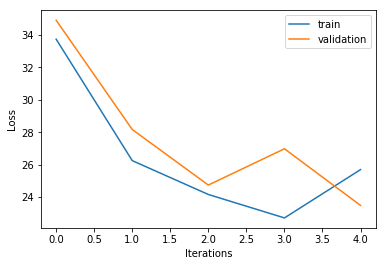

Pour un learning rate de 0.029400000000000003 la training loss atteint la valeur finale 22.806861720932847


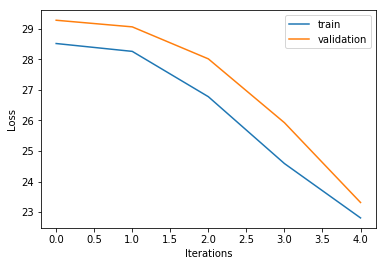

Pour un learning rate de 0.0296 la training loss atteint la valeur finale 24.58178169040794


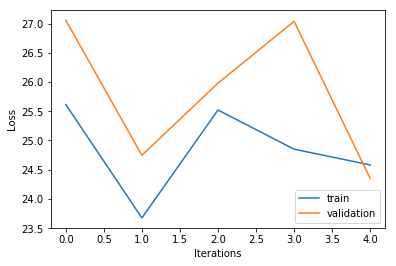

Pour un learning rate de 0.0298 la training loss atteint la valeur finale 24.931598192055393


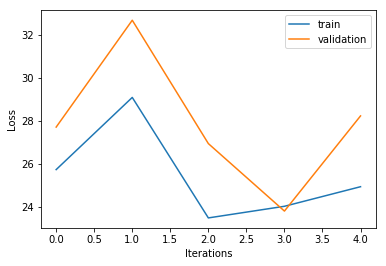

La loss est minimale en fin d'apprentissage pour un learning_rate de 0.0114


In [36]:
lr_list = [i*2*1e-4 for i in range(150)]
LOSS=[]
for lr in lr_list:
    model = MLP()
    lsc = LeastSquareCriterion()
    indices = {}

    indices['train'] = np.random.choice(np.arange(len(train_data)), size=(50,batch_size), replace=False)
    indices['validation'] = np.random.choice(np.arange(len(val_data)),size=(50,batch_size),replace=False)
    
    loss,acc=training(model,lsc,lr,indices)
    print("Pour un learning rate de",lr, "la training loss atteint la valeur finale",loss['train'][-1])
    LOSS.append(loss['train'][-1])
    afficher(loss,"Loss")
    #afficher(acc,"Accuracy")

print("La loss est minimale en fin d'apprentissage pour un learning_rate de",LOSS.index(min(LOSS))*2*1e-4)
# On observe que pour lr > 0.13, la loss diverge. Je n'affiche donc pas ces cas.

In [38]:
# Learning-rate optimal : 0.0114

Pour un batch_size de 1


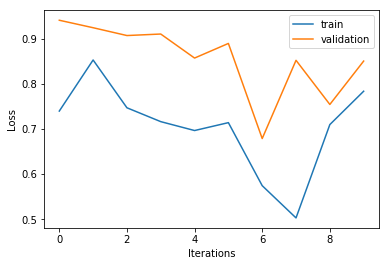

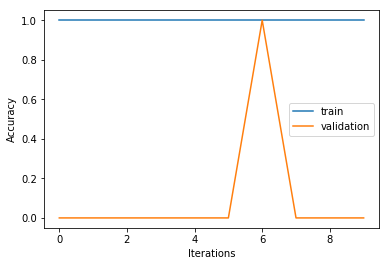

Pour un batch_size de 2


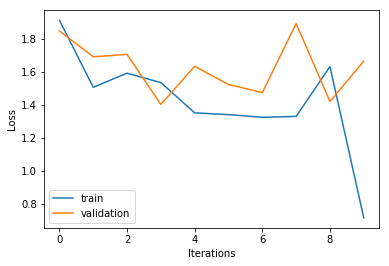

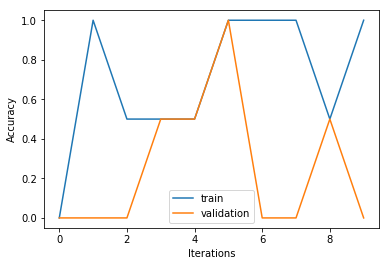

Pour un batch_size de 3


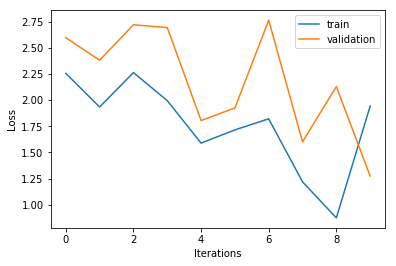

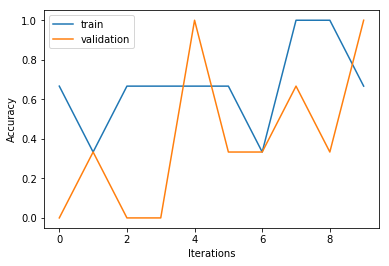

Pour un batch_size de 4


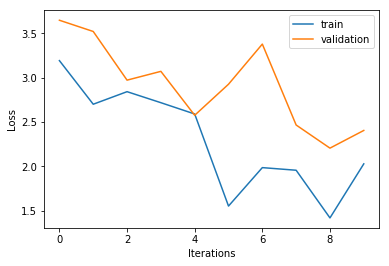

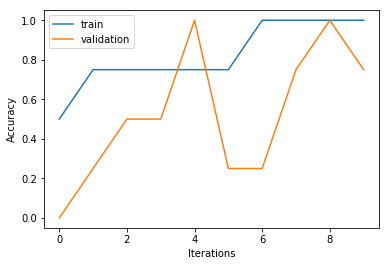

Pour un batch_size de 5


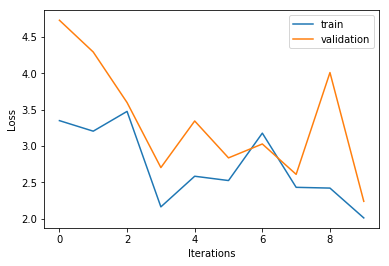

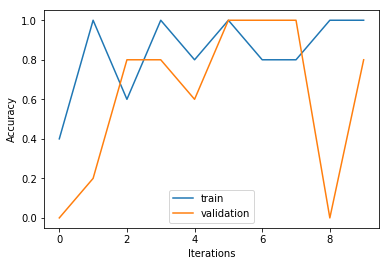

Pour un batch_size de 6


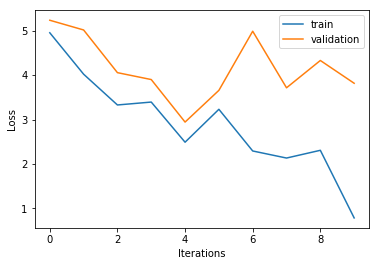

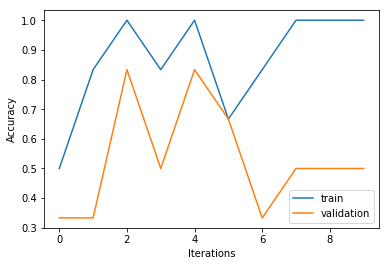

Pour un batch_size de 7


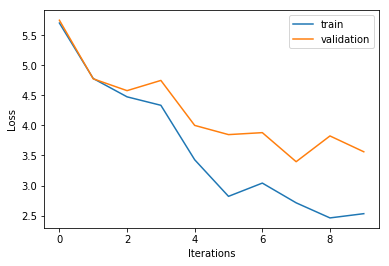

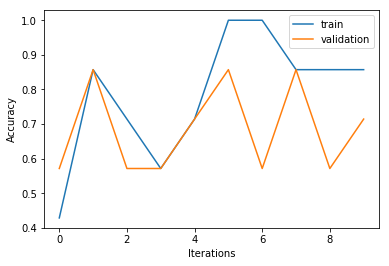

Pour un batch_size de 8


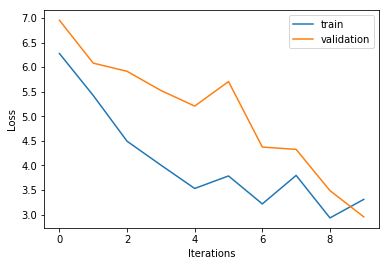

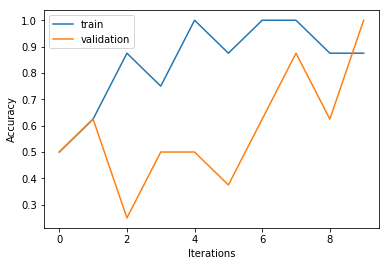

Pour un batch_size de 9


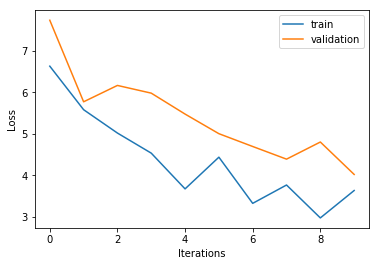

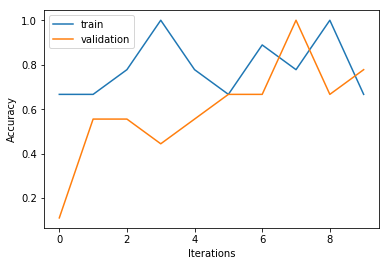

Pour un batch_size de 10


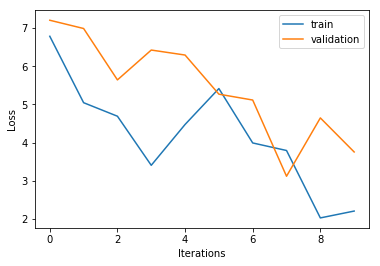

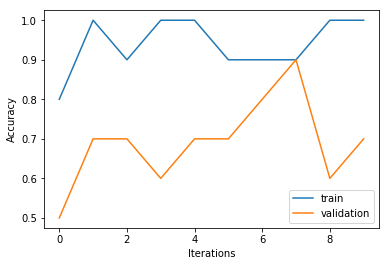

Pour un batch_size de 11


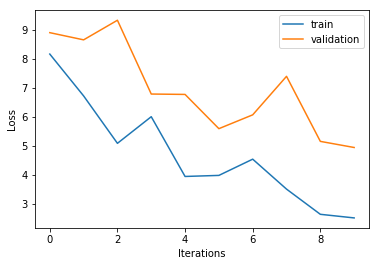

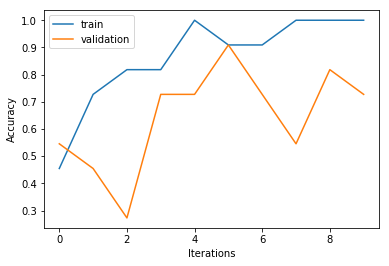

Pour un batch_size de 12


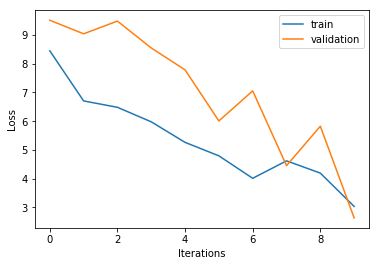

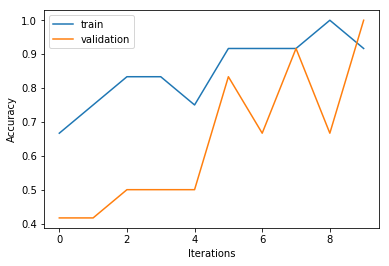

Pour un batch_size de 13


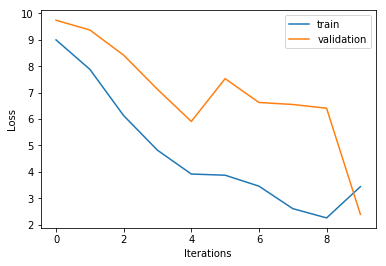

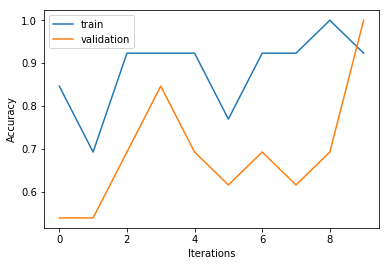

Pour un batch_size de 14


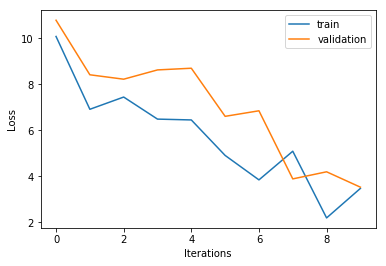

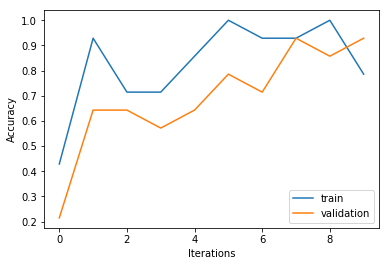

Pour un batch_size de 15


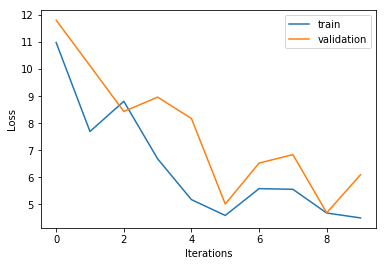

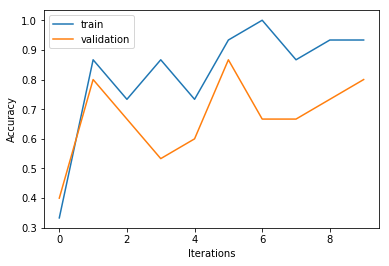

Pour un batch_size de 16


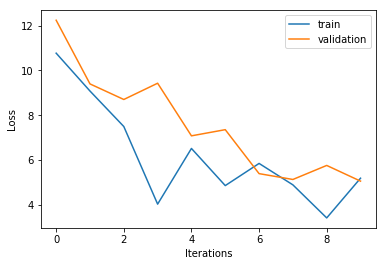

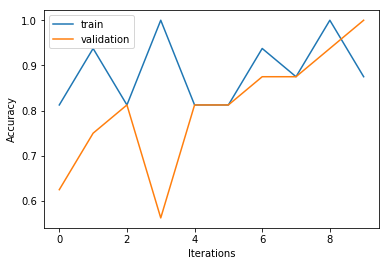

Pour un batch_size de 17


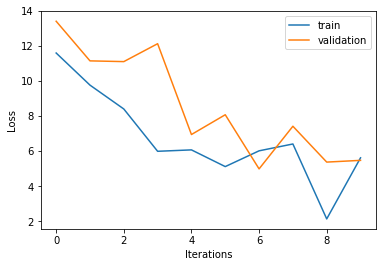

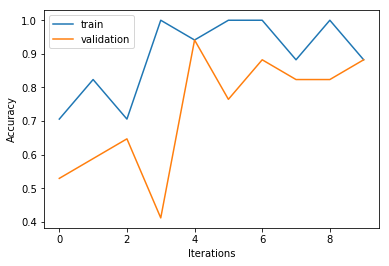

Pour un batch_size de 18


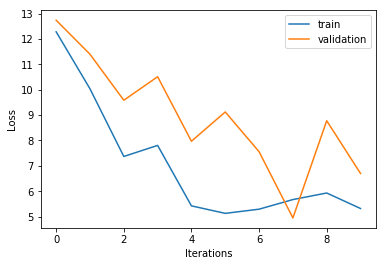

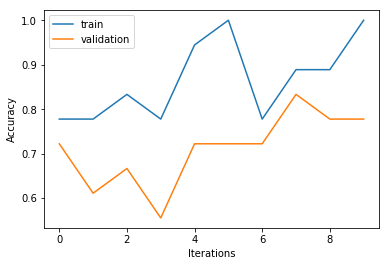

Pour un batch_size de 19


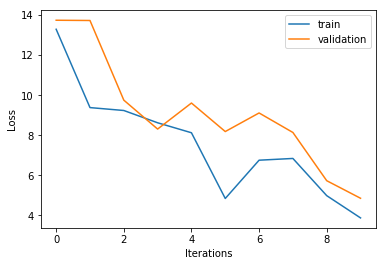

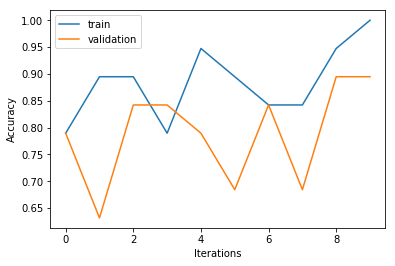

Pour un batch_size de 20


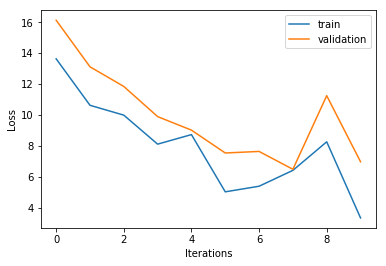

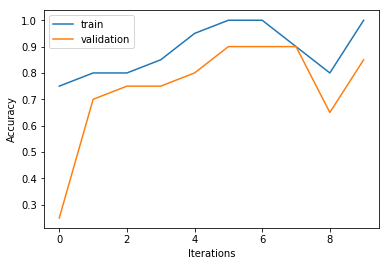

Pour un batch_size de 21


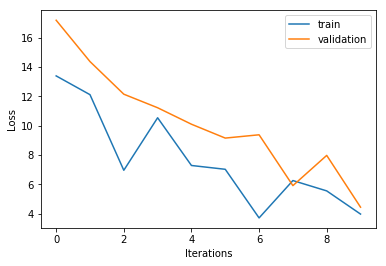

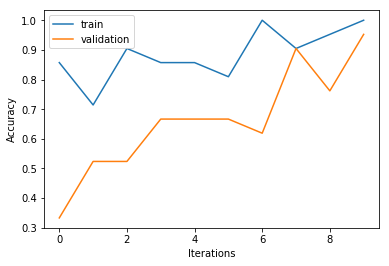

Pour un batch_size de 22


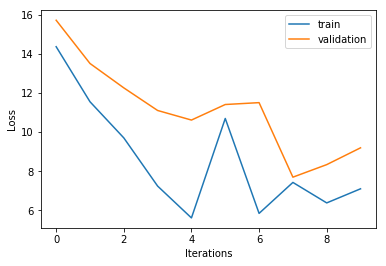

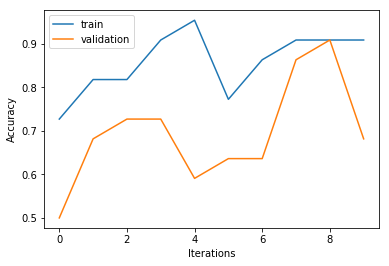

Pour un batch_size de 23


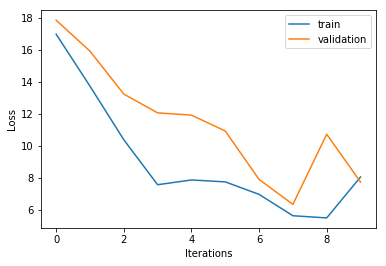

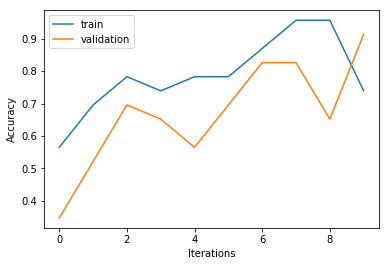

Pour un batch_size de 24


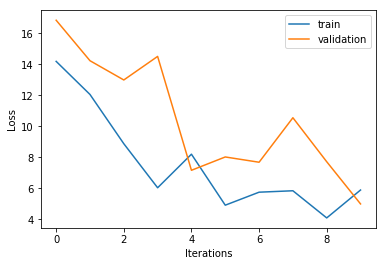

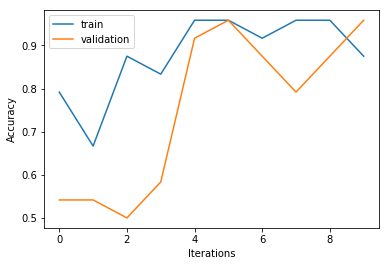

Pour un batch_size de 25


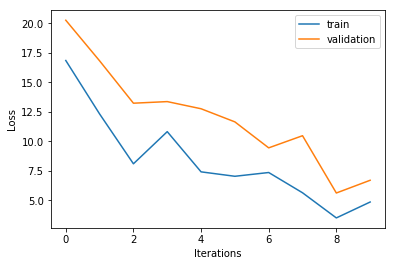

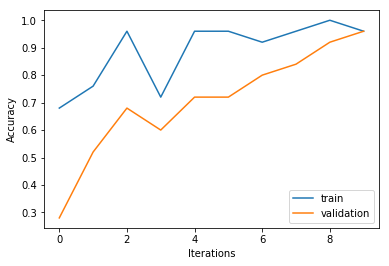

Pour un batch_size de 26


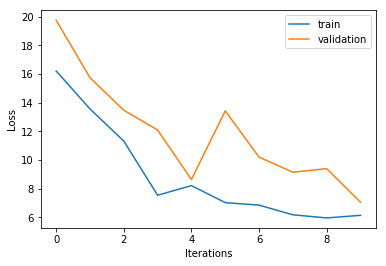

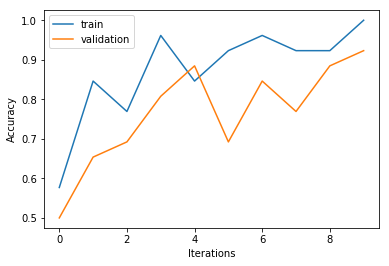

Pour un batch_size de 27


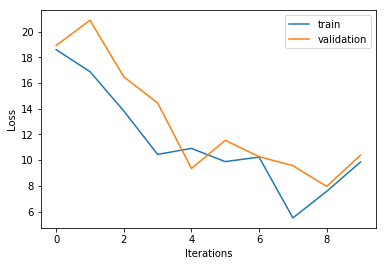

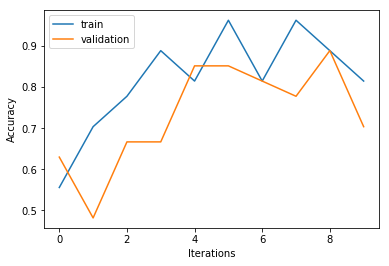

Pour un batch_size de 28


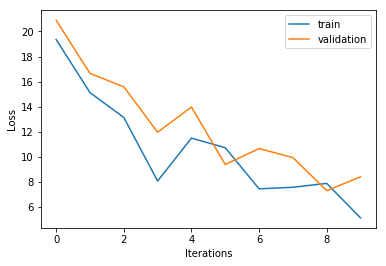

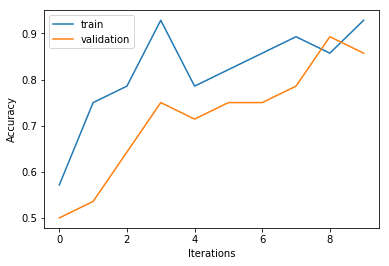

Pour un batch_size de 29


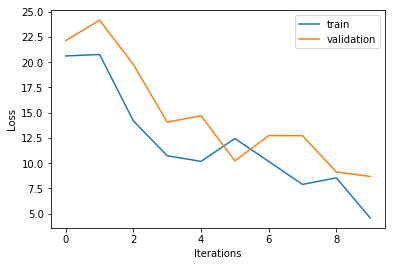

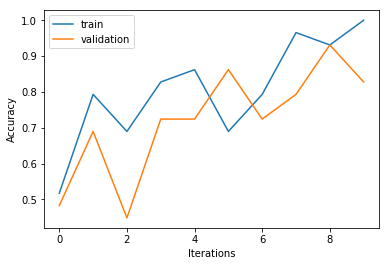

Pour un batch_size de 30


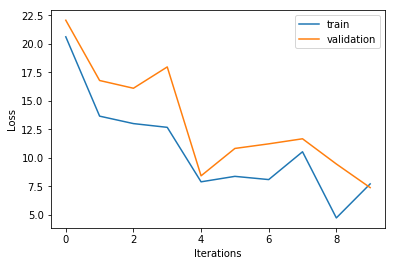

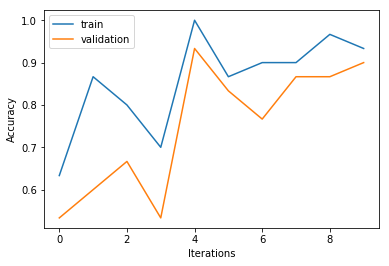

Pour un batch_size de 31


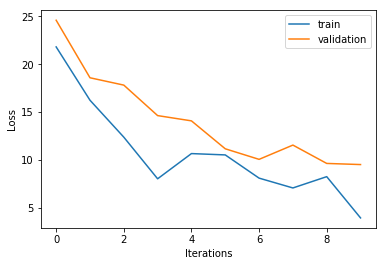

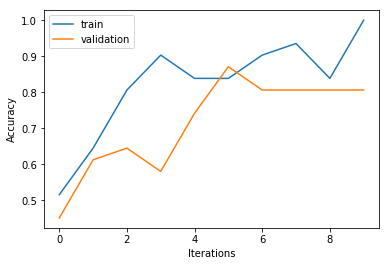

Pour un batch_size de 32


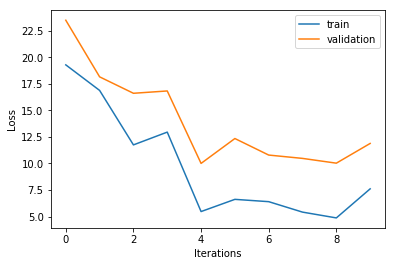

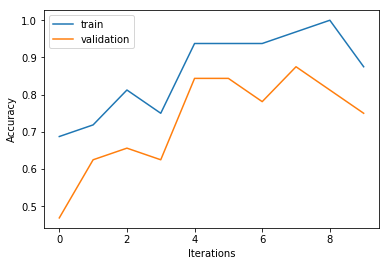

Pour un batch_size de 33


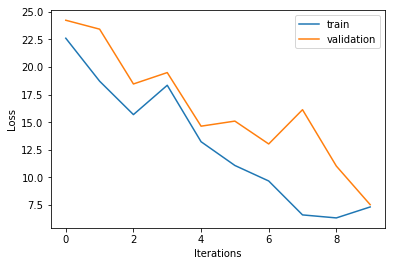

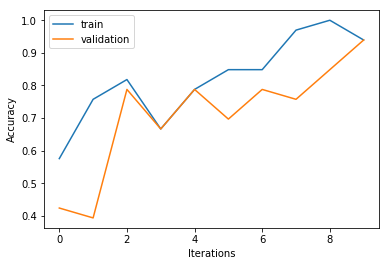

Pour un batch_size de 34


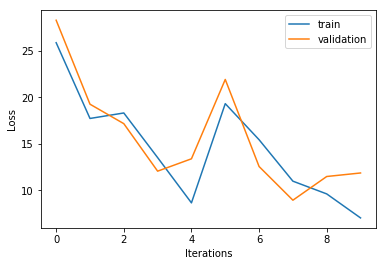

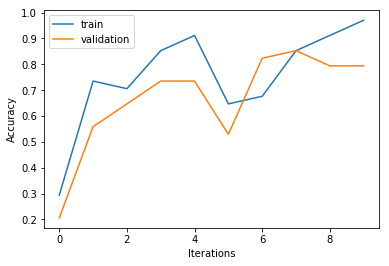

Pour un batch_size de 35


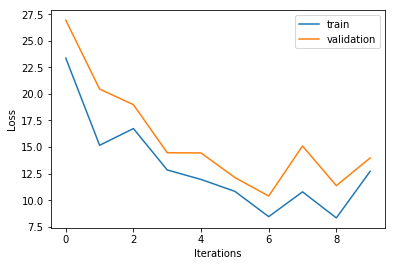

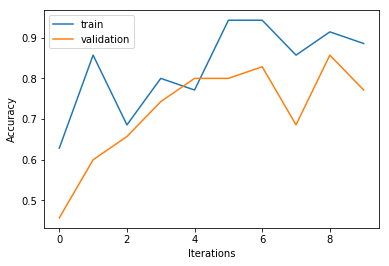

Pour un batch_size de 36


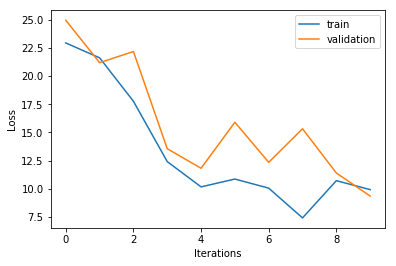

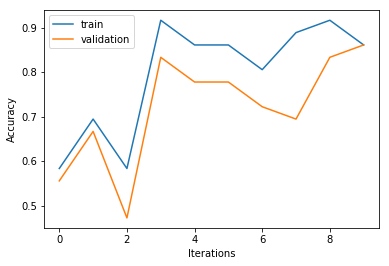

Pour un batch_size de 37


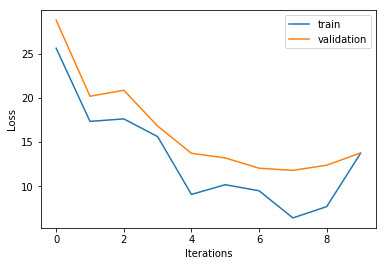

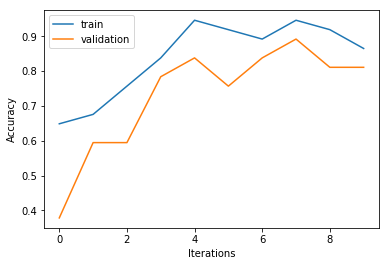

Pour un batch_size de 38


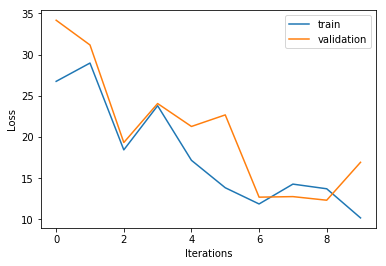

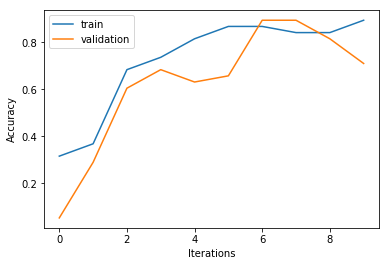

Pour un batch_size de 39


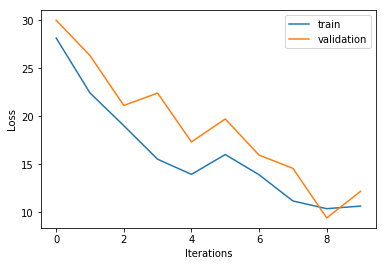

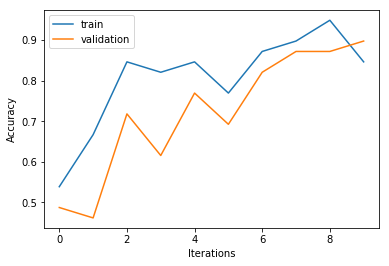

Pour un batch_size de 40


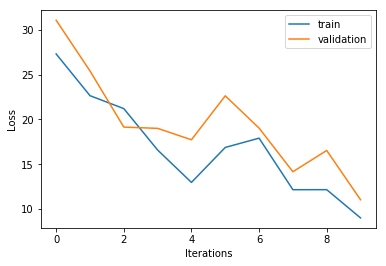

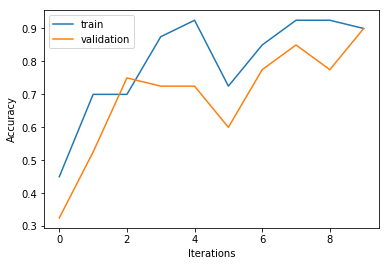

Pour un batch_size de 41


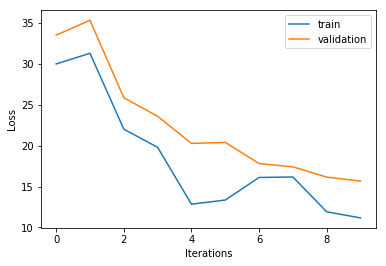

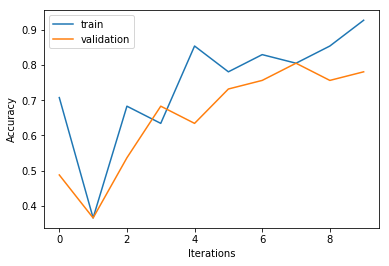

Pour un batch_size de 42


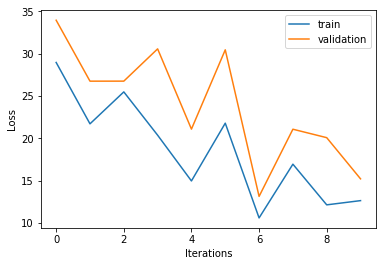

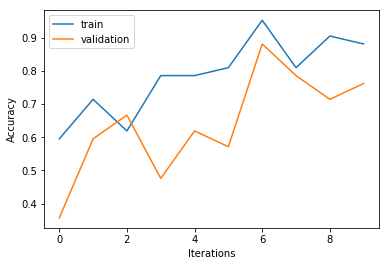

Pour un batch_size de 43


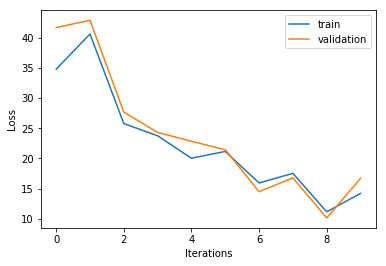

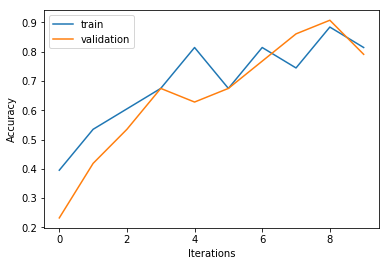

Pour un batch_size de 44


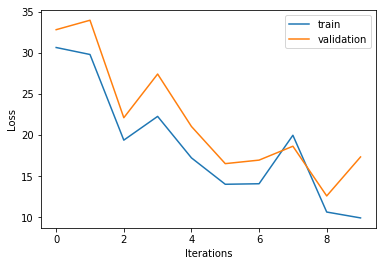

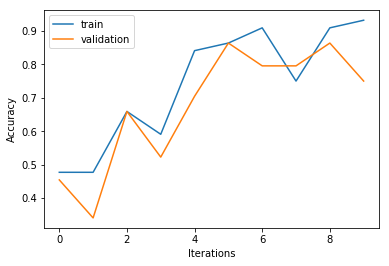

Pour un batch_size de 45


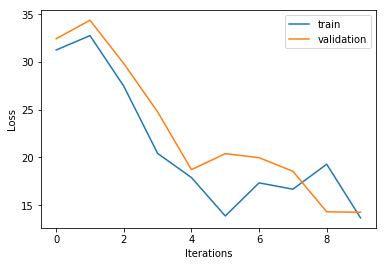

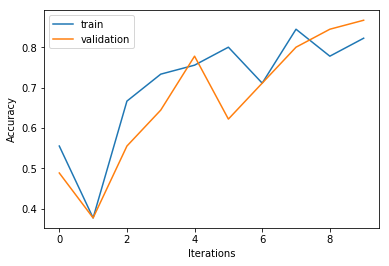

Pour un batch_size de 46


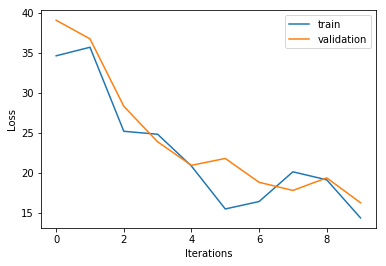

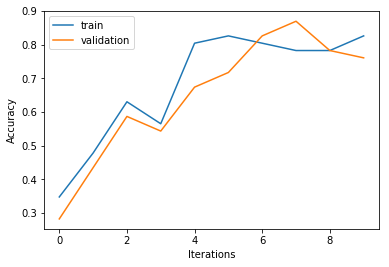

Pour un batch_size de 47


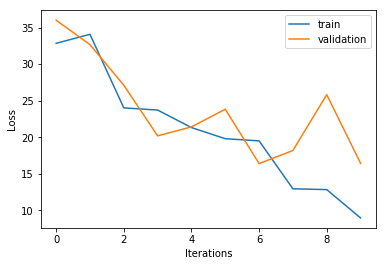

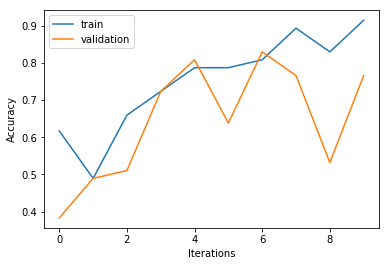

Pour un batch_size de 48


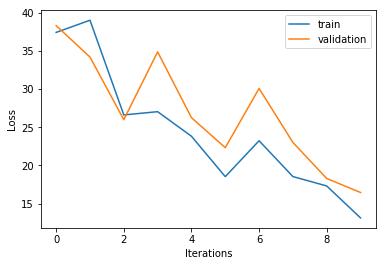

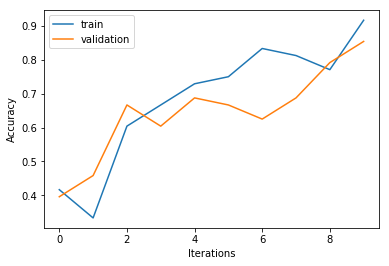

Pour un batch_size de 49


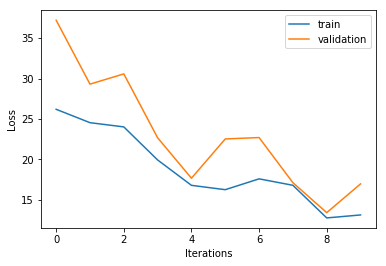

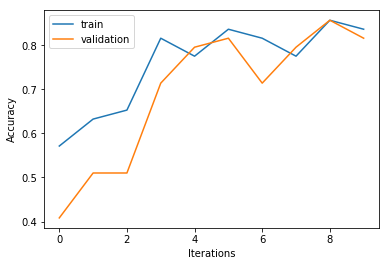

Pour un batch_size de 50


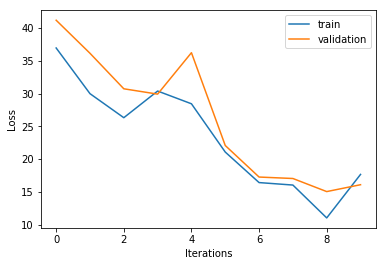

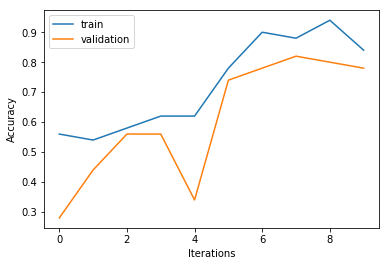

Pour un batch_size de 51


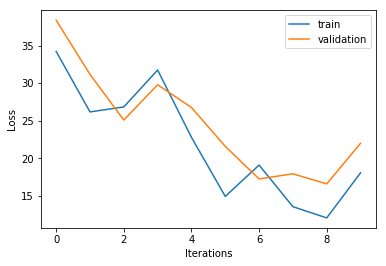

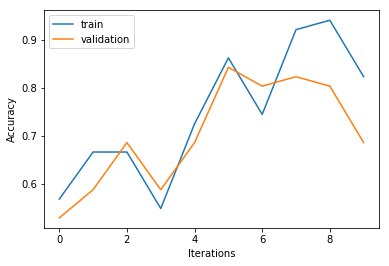

Pour un batch_size de 52


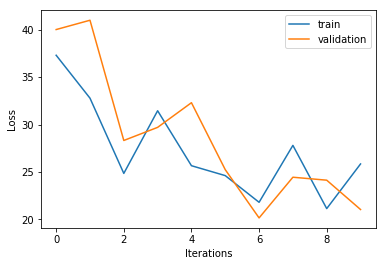

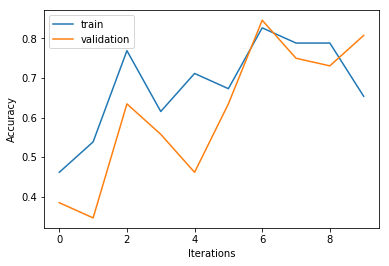

Pour un batch_size de 53


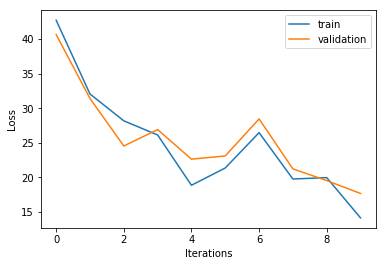

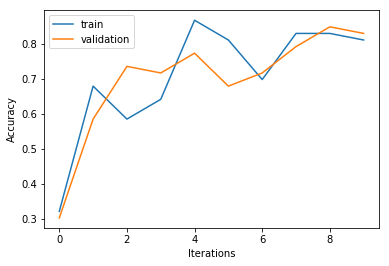

Pour un batch_size de 54


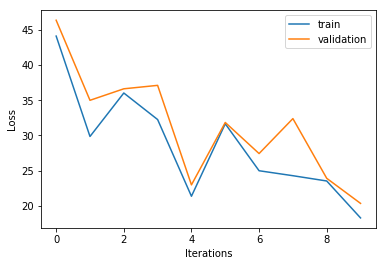

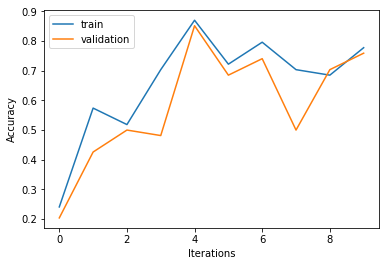

Pour un batch_size de 55


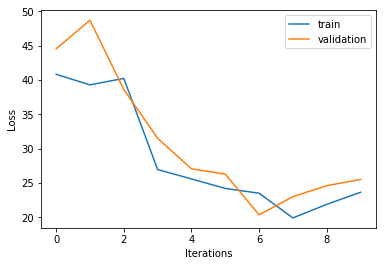

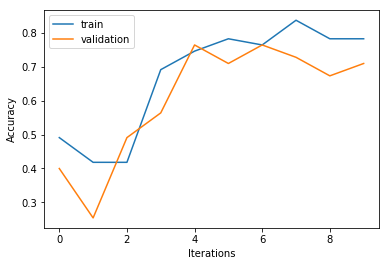

Pour un batch_size de 56


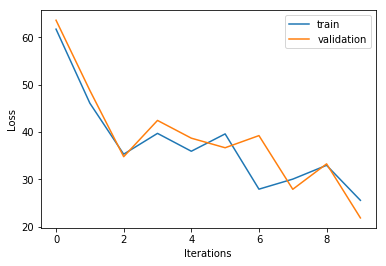

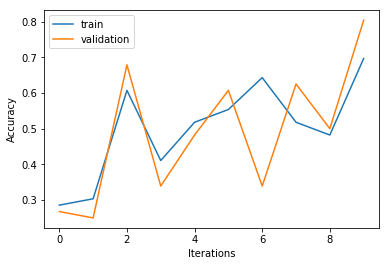

Pour un batch_size de 57


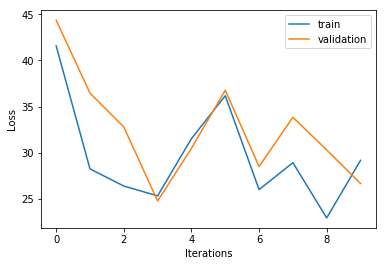

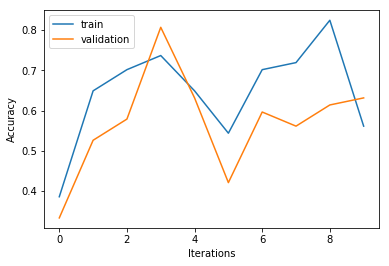

Pour un batch_size de 58


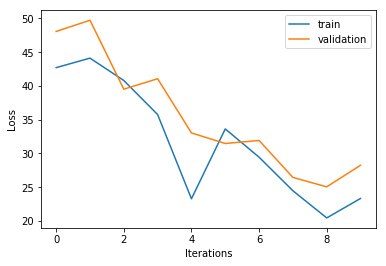

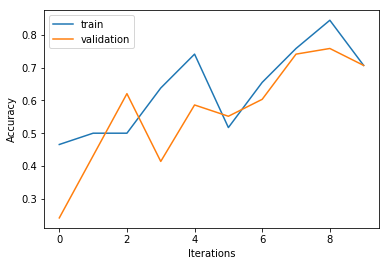

Pour un batch_size de 59


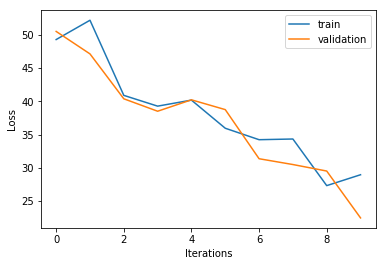

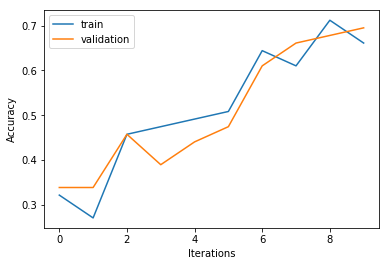

Pour un batch_size de 60


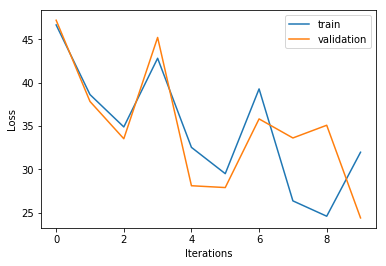

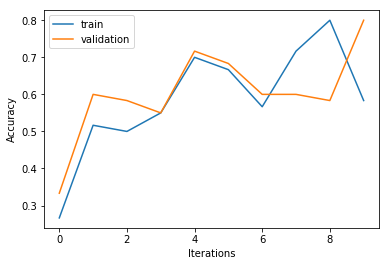

Pour un batch_size de 61


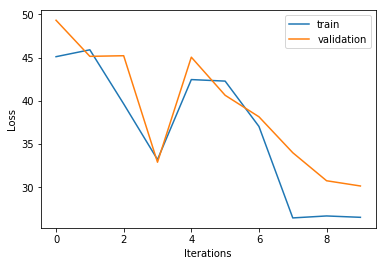

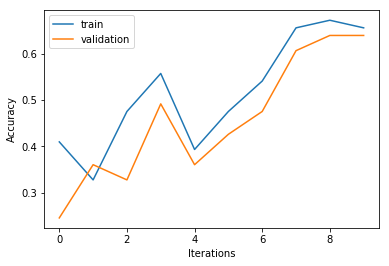

Pour un batch_size de 62


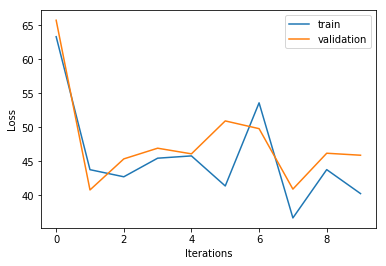

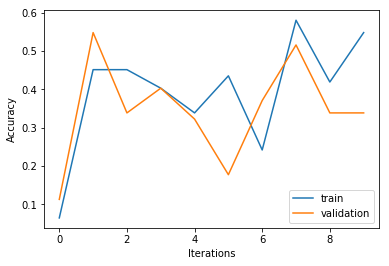

Pour un batch_size de 63


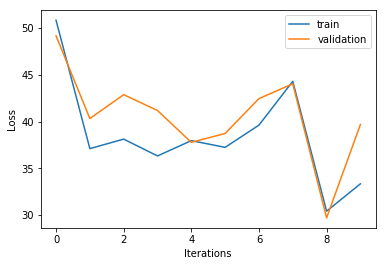

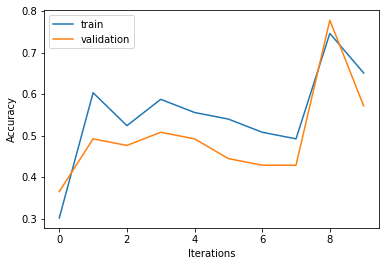

Pour un batch_size de 64


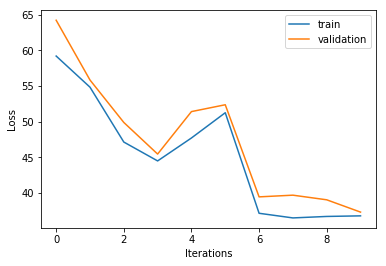

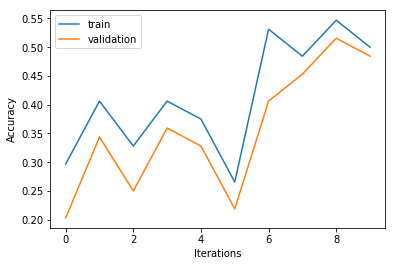

Pour un batch_size de 65


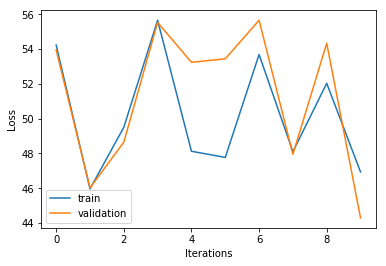

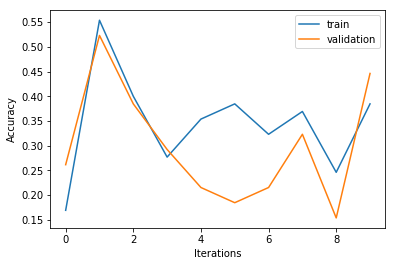

Pour un batch_size de 66


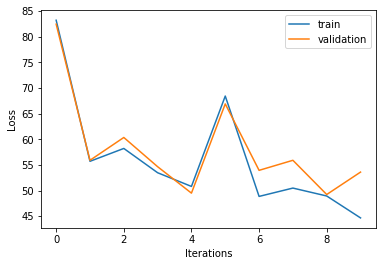

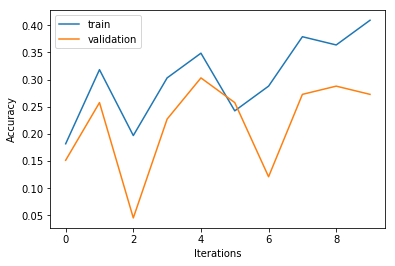

Pour un batch_size de 67


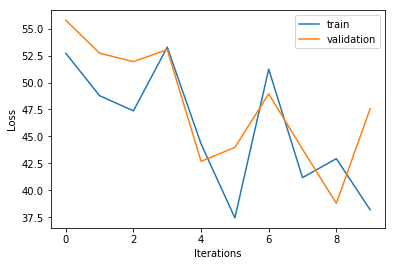

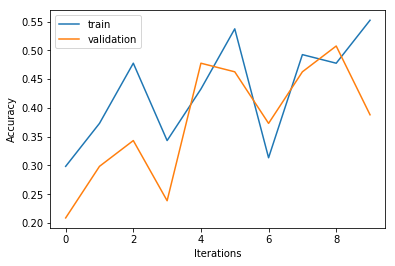

Pour un batch_size de 68


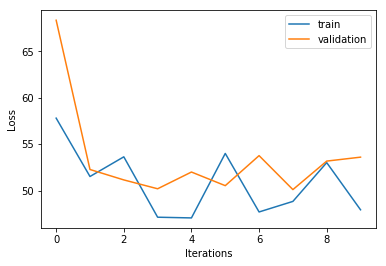

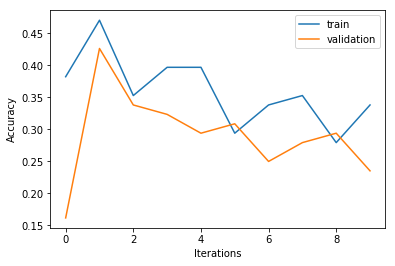

Pour un batch_size de 69


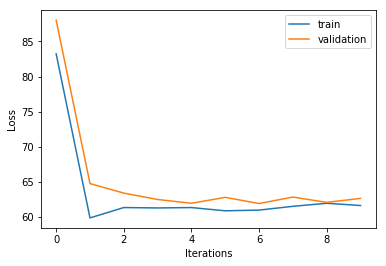

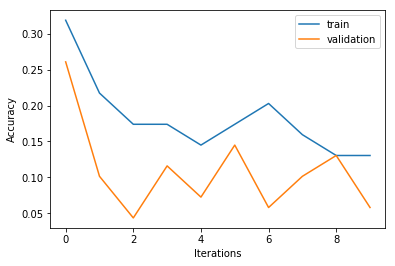

Pour un batch_size de 70


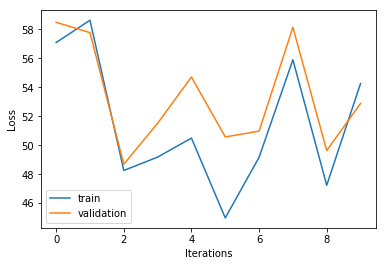

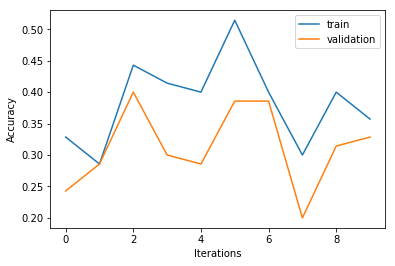

Pour un batch_size de 71


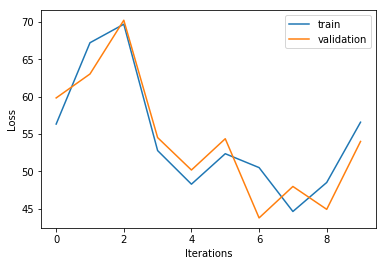

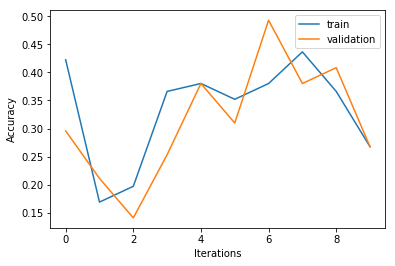

Pour un batch_size de 72


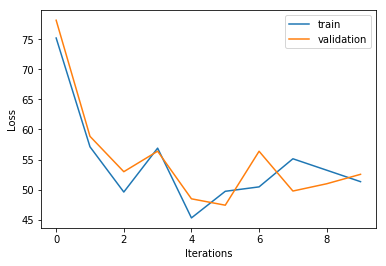

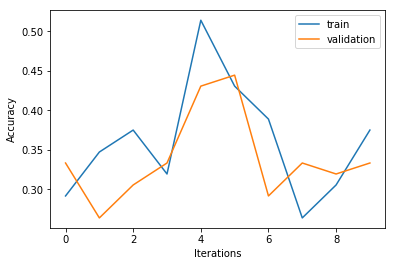

Pour un batch_size de 73


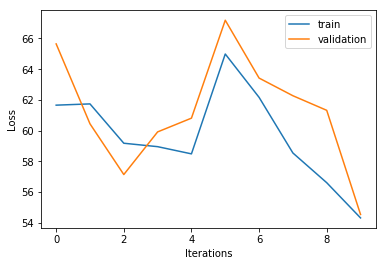

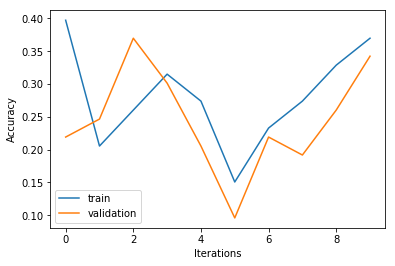

Pour un batch_size de 74


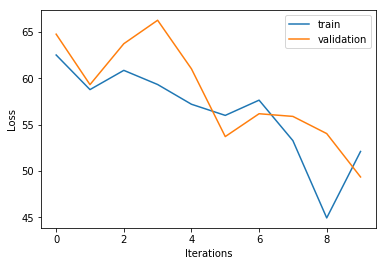

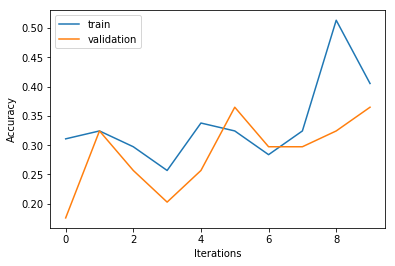

Pour un batch_size de 75


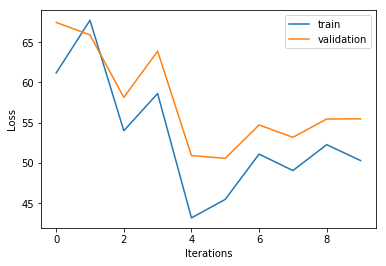

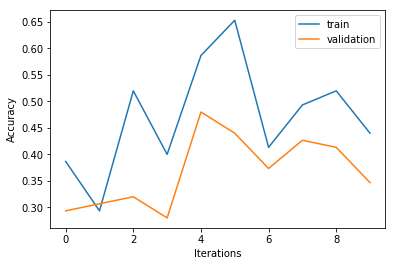

Pour un batch_size de 76


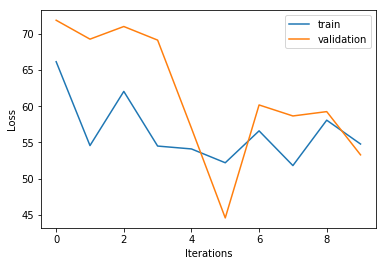

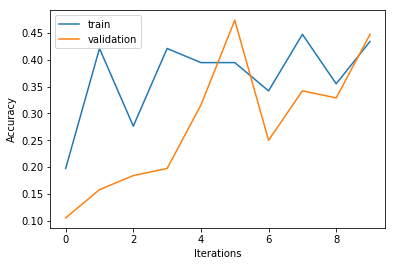

Pour un batch_size de 77


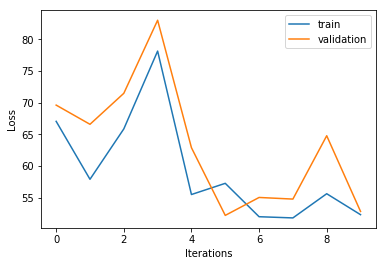

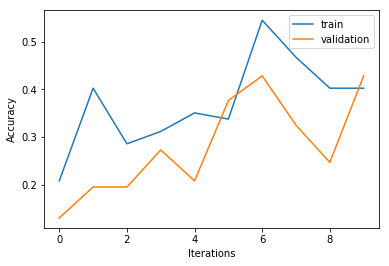

Pour un batch_size de 78


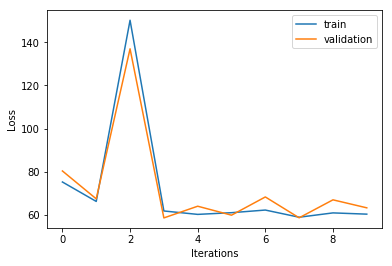

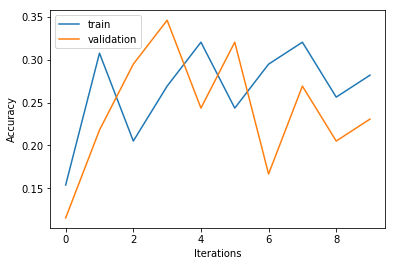

Pour un batch_size de 79


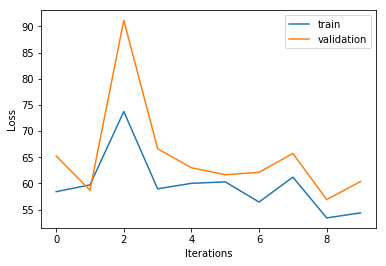

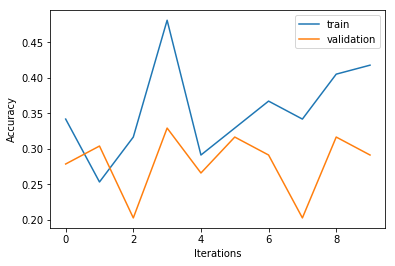

Pour un batch_size de 80


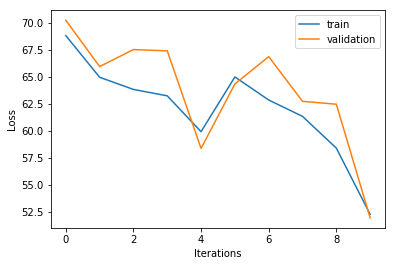

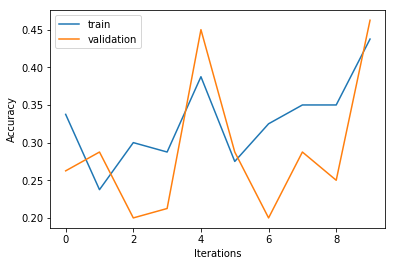

Pour un batch_size de 81


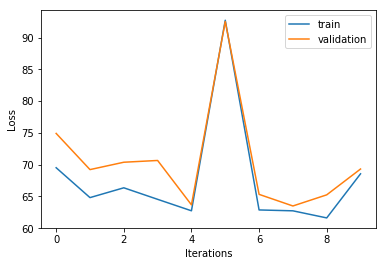

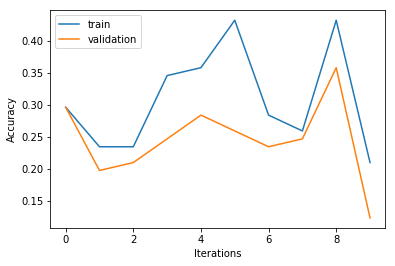

Pour un batch_size de 82


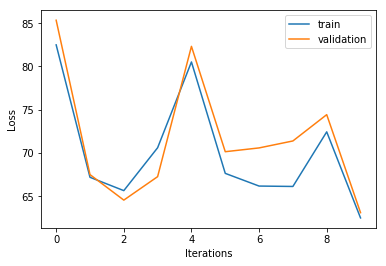

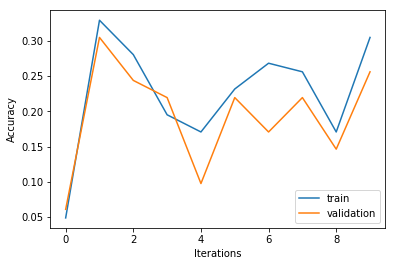

Pour un batch_size de 83


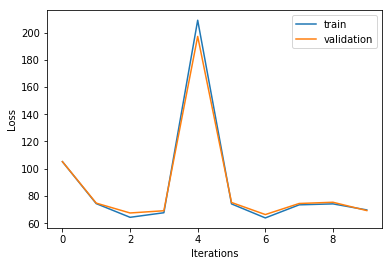

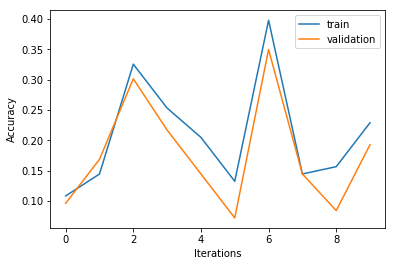

Pour un batch_size de 84


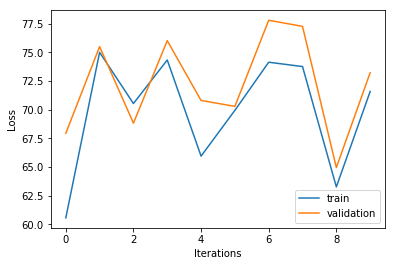

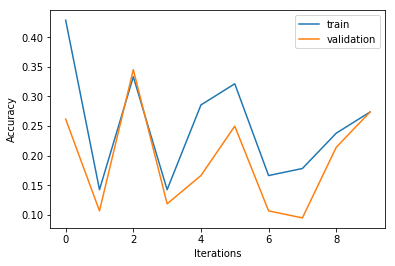

Pour un batch_size de 85


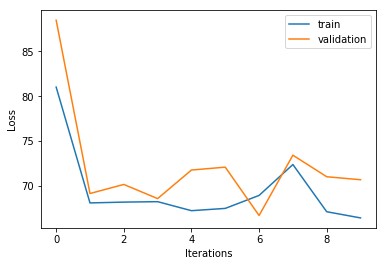

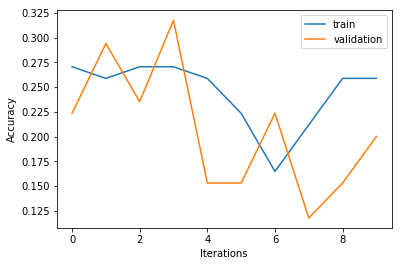

Pour un batch_size de 86


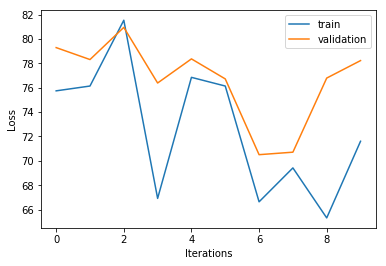

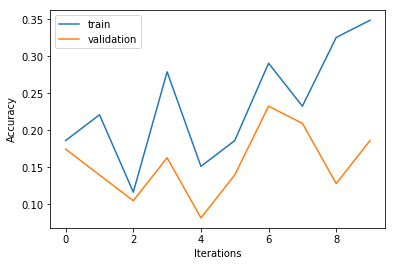

Pour un batch_size de 87


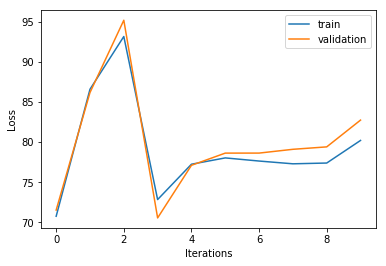

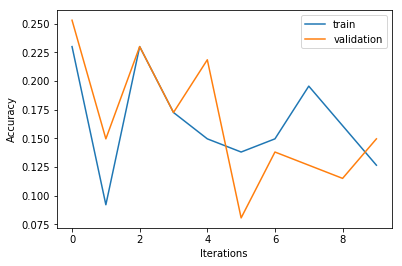

Pour un batch_size de 88


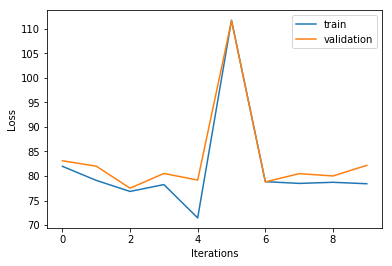

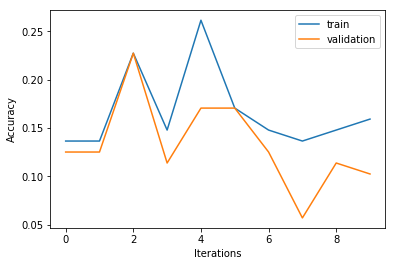

Pour un batch_size de 89


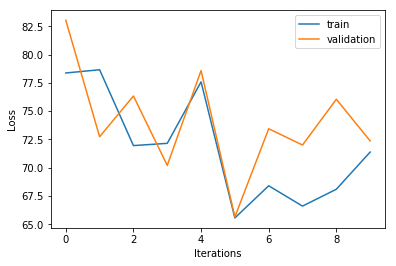

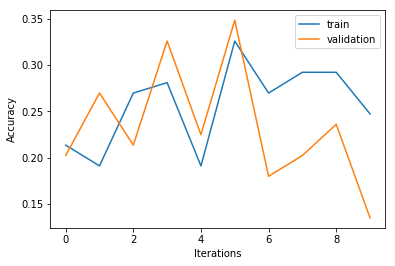

Pour un batch_size de 90


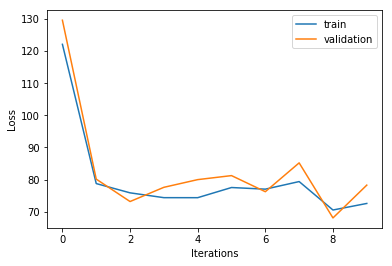

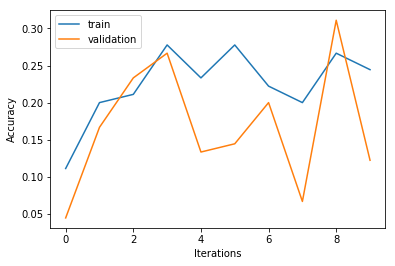

Pour un batch_size de 91


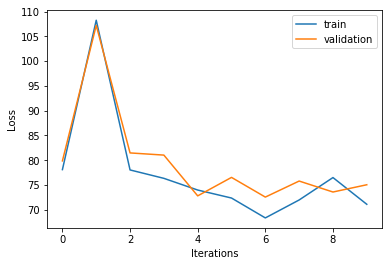

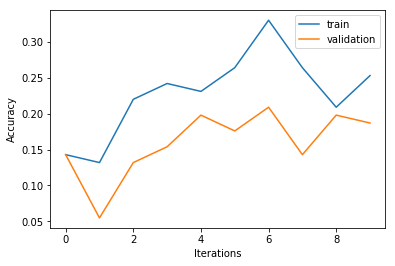

Pour un batch_size de 92


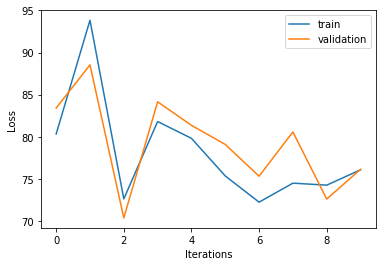

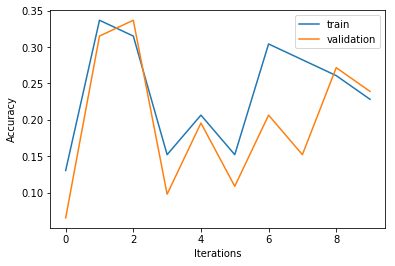

Pour un batch_size de 93


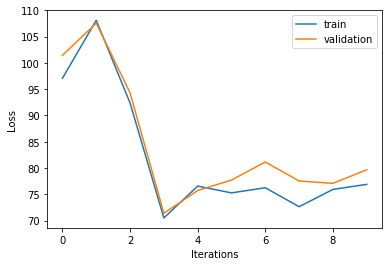

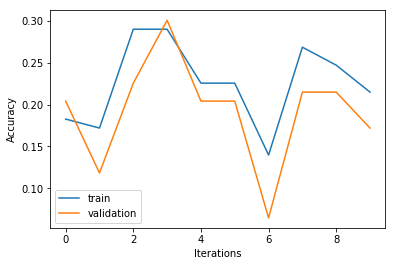

Pour un batch_size de 94


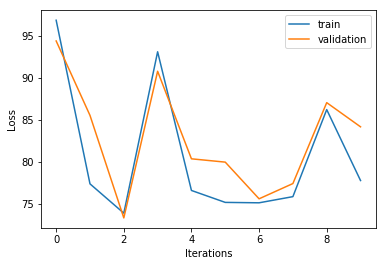

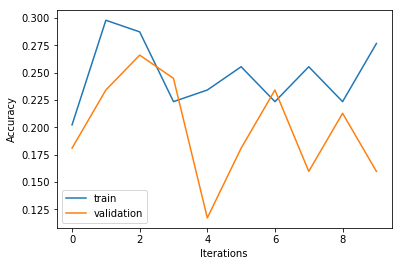

Pour un batch_size de 95


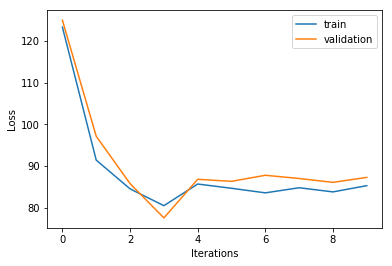

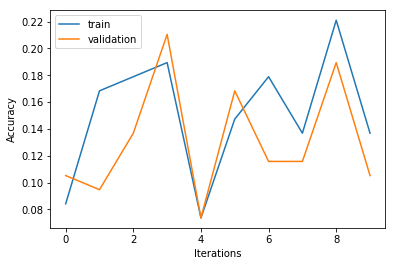

Pour un batch_size de 96


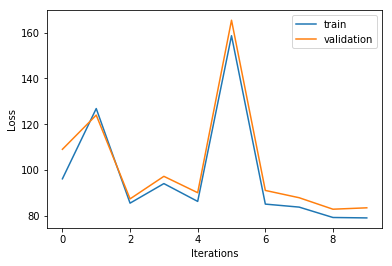

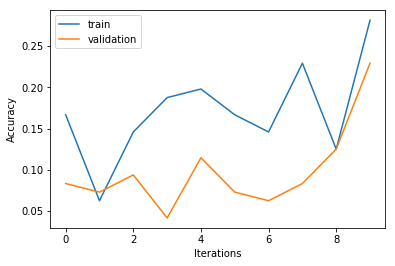

Pour un batch_size de 97


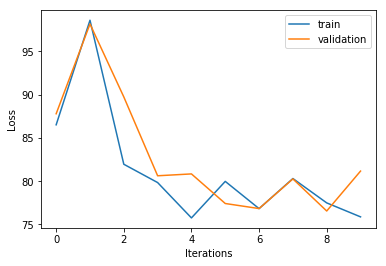

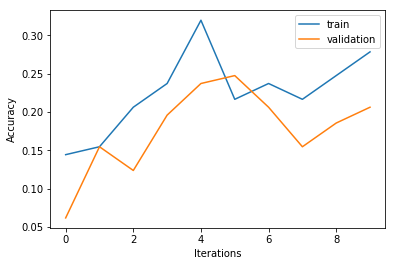

Pour un batch_size de 98


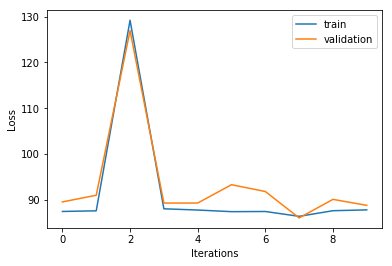

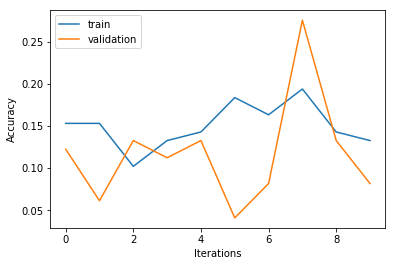

Pour un batch_size de 99


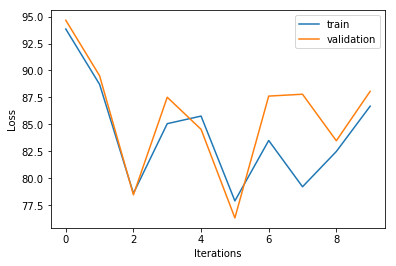

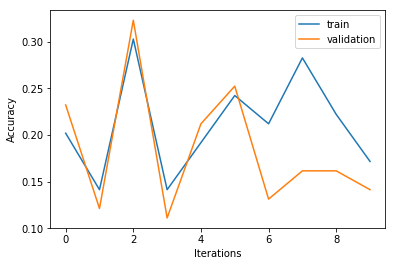

Pour un batch_size de 100


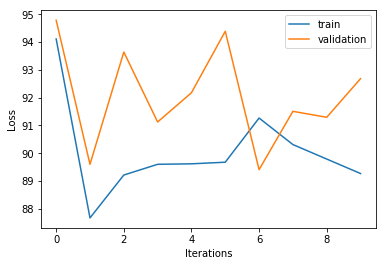

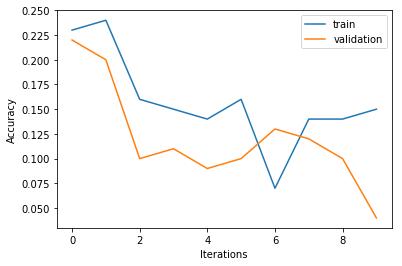

La loss est minimale en fin d'apprentissage pour un batch_size de 1


In [43]:
# On fixe la loss à 0.025 et on fait varier la batch_size
LOSS = []

for batch_size in [i for i in range(1,101)]:
    model = MLP()
    lsc = LeastSquareCriterion()
    lr = 0.014
    indices = {}

    #ind = np.random.randint(len(train_data), size=(1000, batch_size))

    #indices['train'] = ind[500:,:]
    #indices['validation'] = ind[:500, :]

    indices['train'] = np.random.choice(np.arange(len(train_data)), size=(100,batch_size), replace=False)
    indices['validation'] = np.random.choice(np.arange(len(val_data)),size=(100,batch_size),replace=False)
    
    loss,acc=training(model,lsc,lr,indices)
    print("Pour un batch_size de",batch_size)
    LOSS.append(loss['train'][-1])
    afficher(loss,"Loss")
    afficher(acc,"Accuracy")

print("La loss est minimale en fin d'apprentissage pour un batch_size de",LOSS.index(min(LOSS)))

## 2. Overfitting

1/ What's the number of parameters in the network of 1?

In [ ]:
# Il y a 3 couches,
# la première couche à 784 neuronnes (un pour chaque case de la matrice de l'image de taille 28x28)
# la deuxième à 64 neuronnes
# la troisième à 10 neuronnes

# Donc deux matrices de poids de taille 64*784 entre les deux premieres couches
# et de taille 10*64 entre les deux dernières couches

# Il y a aussi deux vecteurs de biais de taille 64 entre les deux premières couches 
# et 10 entre les deux dernières

# En tout, il y a donc 50890 parametres de poids et biais.

2/ Add a parameter to vary the size of the intermediate layer. Design a second type of MLP with 3 linear layers, and parameters for the sizes of the two intermediate layers. (test the associates function)

In [84]:
# Pour la première partie de la question il suffit de changer la fonction _init_ de la classe MLP :

class MLP(Module):

    def __init__(self, num_classes=10,size=64):
        super(MLP, self).__init__()
        self.fc1 = Linear(784, size)
        self.relu1 = ReLU()
        self.fc2 = Linear(size, 10)
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc2.backward(self.relu1.output,gradient)
        gradient = self.relu1.backward(self.fc1.output,gradient)
        gradient = self.fc1.backward(x,gradient)
        return gradient
    
    def gradientStep(self,lr):
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)
        return True

In [85]:
# La réponse à la seconde partie de la question :

class MLP_bis(Module):

    def __init__(self, num_classes=10,sizes=(64,32)):
        super(MLP_bis, self).__init__()
        s1,s2=sizes
        self.fc1 = Linear(784, s1)
        self.relu1 = ReLU()
        self.fc2 = Linear(s1, s2)
        self.fc3 = Linear(s2, 10)
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        x = self.fc3.forward(x)
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc3.backward(self.fc2.output,gradient)
        gradient = self.fc2.backward(self.relu1.output,gradient)
        gradient = self.relu1.backward(self.fc1.output,gradient)
        gradient = self.fc1.backward(x,gradient)
        return gradient
    
    def gradientStep(self,lr):
        self.fc3.gradientStep(lr)
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)
        return True

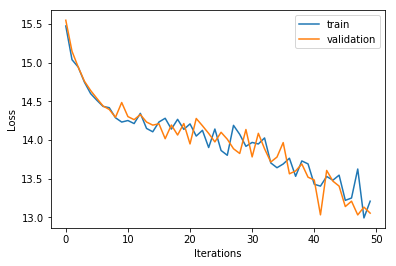

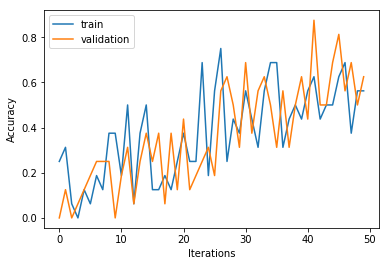

In [119]:
model = MLP_bis()
lsc = LeastSquareCriterion()
lr = 0.001
batch_size=16
indices = {}

indices['train'] = np.random.choice(np.arange(len(train_data)), size=(500,batch_size), replace=False)
indices['validation'] = np.random.choice(np.arange(len(val_data)),size=(500,batch_size),replace=False)

loss,acc=training(model,lsc,lr,indices)

afficher(loss,'Loss')
afficher(acc,"Accuracy")

3/ Keeping the training procedure fixed, test different size of networks and layers. Show evidence of overfitting.

In [151]:
# fonction de lissage volée ici :
# https://openclassrooms.com/forum/sujet/lisser-une-courbe-de-valeurs-experimentales

def lissage(Lx,Ly,p):
    '''Fonction qui débruite une courbe par une moyenne glissante
    sur 2P+1 points'''
    Lxout=[]
    Lyout=[]
    for i in range(p,len(Lx)-p):   
        Lxout.append(Lx[i])
    for i in range(p,len(Ly)-p):
        val=0
        for k in range(2*p):
            val+=Ly[i-p+k]
        Lyout.append(val/2/p)
            
    return Lxout,Lyout

def afficher_lisser(dic,nom):
    X, loss_train_lisse = lissage([i for i in range(len(dic['train']))],dic['train'],10)
    X, loss_val_lisse = lissage([i for i in range(len(dic['validation']))],dic['validation'],10)
    plt.plot(X,loss_train_lisse,label='Train')
    plt.xlabel('Itérations')
    plt.ylabel(nom)
    plt.plot(X,loss_val_lisse,label='Validation')
    plt.legend()
    plt.show()

On est sur le cas simple 10


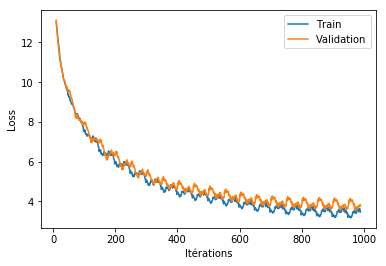

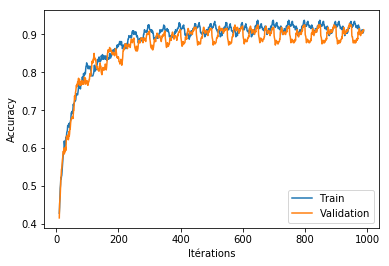

On est sur le cas simple 100


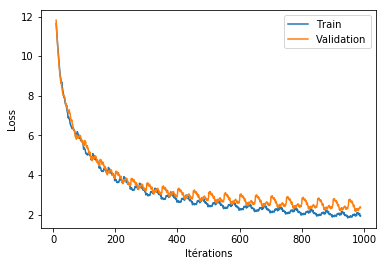

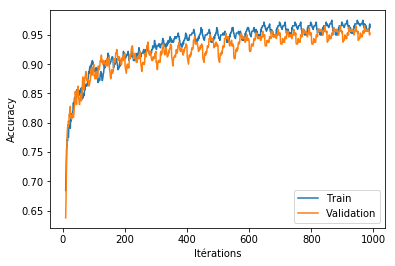

On est sur le cas double 64,32


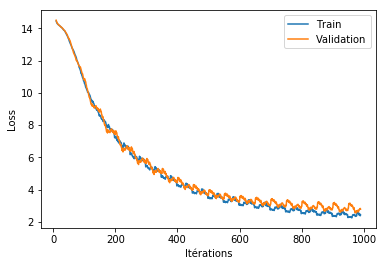

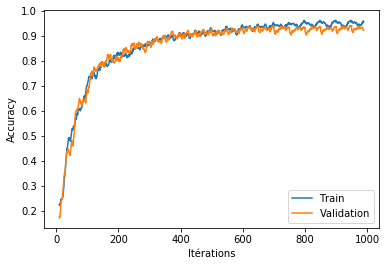

On est sur le cas double 128,64


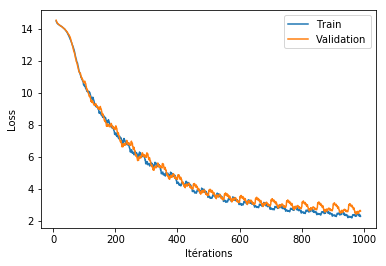

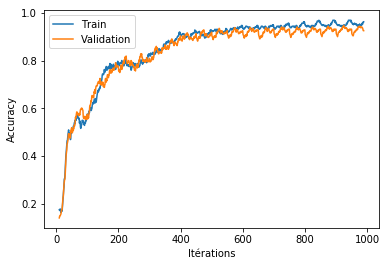

On est sur le cas double 100,100


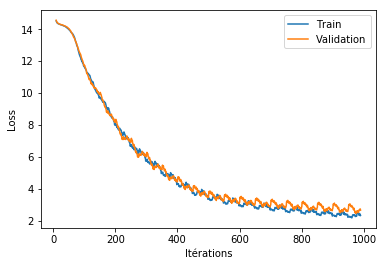

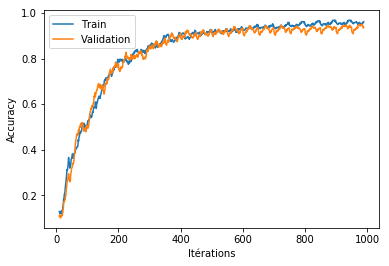

On est sur le cas double 200,200


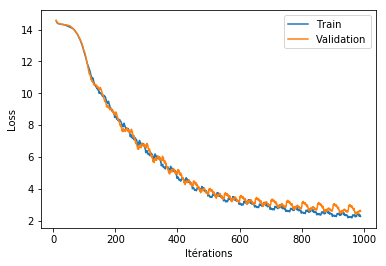

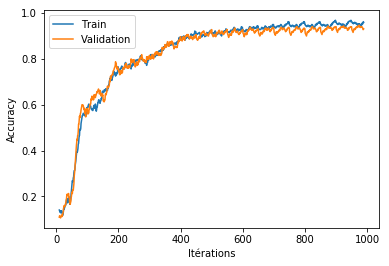

In [152]:
MLPs=[MLP(size=10),MLP(size=100),MLP_bis(sizes=(64,32)),MLP_bis(sizes=(128,64)),MLP_bis(sizes=(100,100)),MLP_bis(sizes=(200,200))]
MLPs_noms = ["simple 10", "simple 100", "double 64,32", "double 128,64","double 100,100","double 200,200"]

lsc = LeastSquareCriterion()
lr = 0.001
batch_size=16
indices = {}
nombre_epoch = 20

indices['train'] = np.random.choice(np.arange(len(train_data)), size=(500,batch_size), replace=False)
indices['validation'] = np.random.choice(np.arange(len(val_data)),size=(500,batch_size),replace=False)

for mlp,nom in zip(MLPs,MLPs_noms):
    model=mlp
    loss_train,loss_val=[],[]
    acc_train,acc_val=[],[]
    for _ in range (nombre_epoch):
        loss,acc=training(model,lsc,lr,indices)
        #print(acc)
        loss_train += loss['train']
        loss_val += loss['validation']
        acc_train += acc['train']
        acc_val += acc['validation']
    print("On est sur le cas",nom)
    
    dic_loss, dic_acc = {},{}
    
    dic_loss['train'] = loss_train
    dic_loss['validation'] = loss_val
    
    dic_acc['train'] = acc_train
    dic_acc['validation'] = acc_val
    
    afficher_lisser(dic_loss,"Loss")
    afficher_lisser(dic_acc,"Accuracy")

On est sur le cas double 200,200


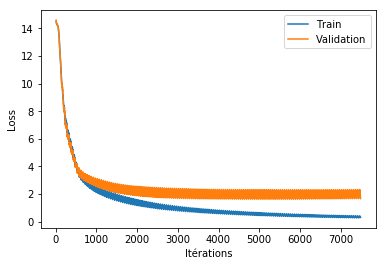

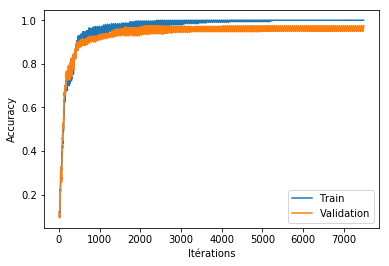

In [154]:
MLPs=[MLP_bis(sizes=(200,200))]
MLPs_noms = ["double 200,200"]

lsc = LeastSquareCriterion()
lr = 0.001
batch_size=16
indices = {}
nombre_epoch = 150

indices['train'] = np.random.choice(np.arange(len(train_data)), size=(500,batch_size), replace=False)
indices['validation'] = np.random.choice(np.arange(len(val_data)),size=(500,batch_size),replace=False)

for mlp,nom in zip(MLPs,MLPs_noms):
    model=mlp
    loss_train,loss_val=[],[]
    acc_train,acc_val=[],[]
    for _ in range (nombre_epoch):
        loss,acc=training(model,lsc,lr,indices)
        #print(acc)
        loss_train += loss['train']
        loss_val += loss['validation']
        acc_train += acc['train']
        acc_val += acc['validation']
    print("On est sur le cas",nom)
    
    dic_loss, dic_acc = {},{}
    
    dic_loss['train'] = loss_train
    dic_loss['validation'] = loss_val
    
    dic_acc['train'] = acc_train
    dic_acc['validation'] = acc_val
    
    afficher_lisser(dic_loss,'Loss')
    afficher_lisser(dic_acc,"Accuracy")

In [142]:
# On constate donc que pour MLP_bis(size=(200,200)) et 150 epochs, on commence à voir un overfitting
# car la train loss continue a diminuer mais la validation loss stagne un moment puis commence a remonter

4/ Add an optionnal parameter for weight decay (in the gradientStep functions) and show that it can reduce overfitting in some cases (improving the validation performance may be hard, you would have to look at a setting with very little training data to see, you can focus on showing that the gap between training and validation performance decreases)

In [178]:
# On modifie la fonction gradientStep pour obtenir la classe suivante :

class Linear_bis(Module):
    """
    The input is supposed to have two dimensions (batchSize,in_feature)
    """
    def __init__(self, in_features, out_features, bias=True):
        super(Linear_bis, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = math.sqrt(1. / (out_features* in_features))*np.random.randn(out_features, in_features)
        self.bias = np.zeros(out_features)
        self.gradWeight=None
        self.gradBias=None
        
    def forward(self, x):
        self.output= np.dot(x,self.weight.transpose())+np.repeat(self.bias.reshape([1,-1]),x.shape[0], axis=0)
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput=np.dot(gradOutput,self.weight)
        self.gradWeight=np.dot(gradOutput.transpose(),x)
        self.gradBias=np.sum(gradOutput, axis=0)
        return self.gradInput
    
    def gradientStep(self,lr,weight):
        self.weight=self.weight-lr*(self.gradWeight+weight*self.weight)
        self.bias=self.bias-lr*self.gradBias

class MLP_bis_weight(Module):

    def __init__(self, num_classes=10, sizes = (64, 64), weight = (0, 0, 0)):
        super(MLP_bis_weight, self).__init__()
        s1, s2 = sizes
        self.fc1 = Linear_bis(784, s1)
        self.relu1 = ReLU()
        self.fc2 = Linear_bis(s1, s2)
        self.fc3 = Linear_bis(s2, 10)
        self.weight = weight
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        x = self.fc3.forward(x)
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc3.backward(self.fc2.output,gradient)
        gradient = self.fc2.backward(self.relu1.output,gradient)
        gradient = self.relu1.backward(self.fc1.output,gradient)
        gradient = self.fc1.backward(x,gradient)
        return gradient
    
    def gradientStep(self,lr):
        wd1, wd2, wd3 = self.weight
        self.fc3.gradientStep(lr, weight=wd1)
        self.fc2.gradientStep(lr, weight=wd2)
        self.fc1.gradientStep(lr, weight=wd3)
        return True

On est sur le cas w= (0, 0, 0)


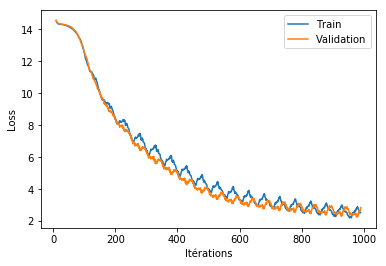

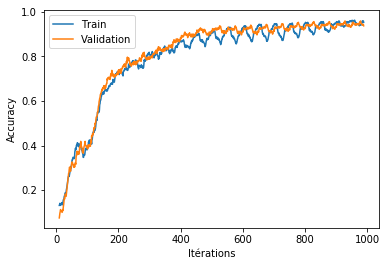

On est sur le cas w= (0.1, 0.01, 0.01)


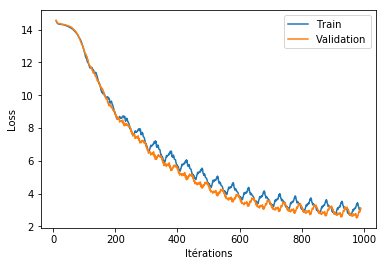

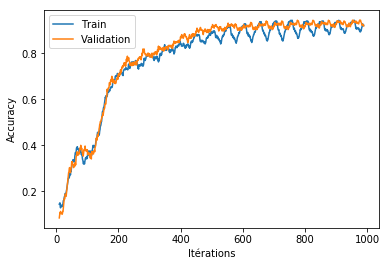

On est sur le cas w= (0.1, 0.1, 0.01)


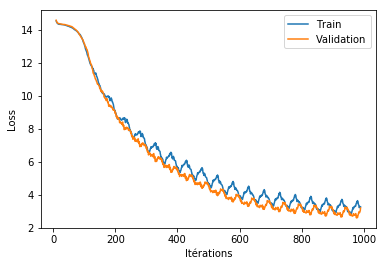

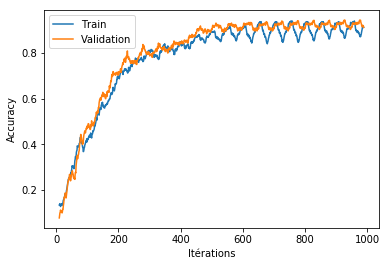

On est sur le cas w= (0.1, 0.1, 0.1)


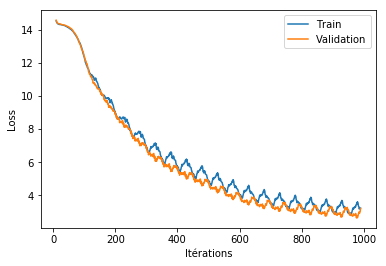

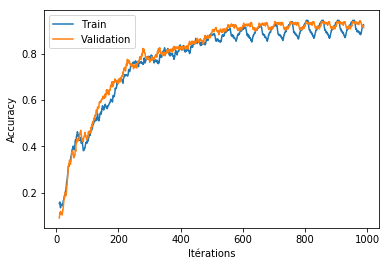

On est sur le cas w= (1, 0.1, 0.1)


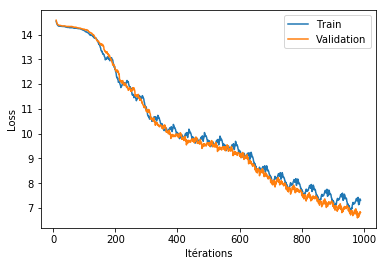

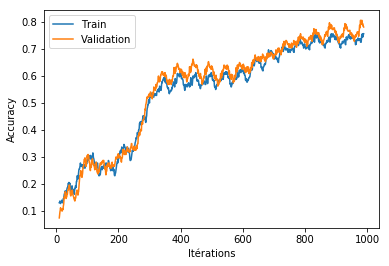

On est sur le cas w= (1, 1, 0.1)


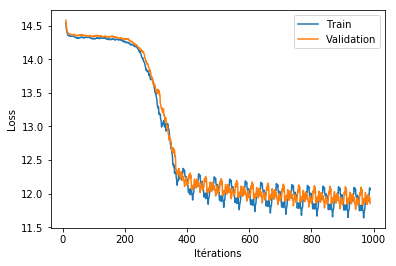

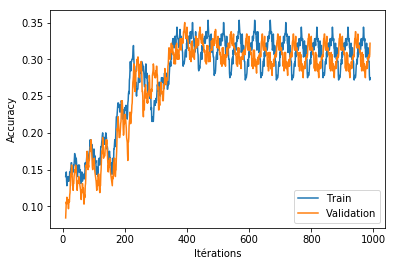

On est sur le cas w= (1, 1, 1)


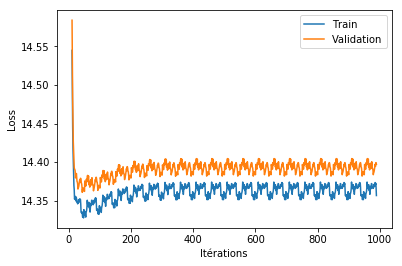

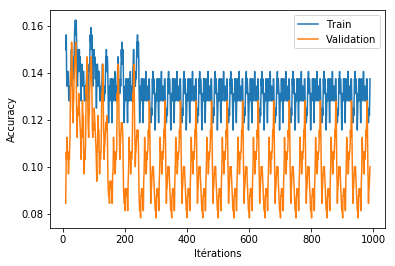

In [179]:
weight = [(0, 0, 0), (0.1, 0.01, 0.01), (0.1, 0.1, 0.01), (0.1, 0.1, 0.1),(1, 0.1, 0.1), (1, 1, 0.1), (1, 1, 1)]
lsc = LeastSquareCriterion()
lr = 0.001
batch_size=16
indices = {}
nombre_epoch = 20

indices['train'] = np.random.choice(np.arange(len(train_data)), size=(500,batch_size), replace=False)
indices['validation'] = np.random.choice(np.arange(len(val_data)),size=(500,batch_size),replace=False)

for w in weight:
    model=MLP_bis_weight(sizes=(200, 200),weight=w)
    loss_train,loss_val=[],[]
    acc_train,acc_val=[],[]
    for _ in range (nombre_epoch):
        loss,acc=training(model,lsc,lr,indices)
        loss_train += loss['train']
        loss_val += loss['validation']
        acc_train += acc['train']
        acc_val += acc['validation']
    print("On est sur le cas w=",w)
    
    dic_loss, dic_acc = {},{}
    
    dic_loss['train'] = loss_train
    dic_loss['validation'] = loss_val
    
    dic_acc['train'] = acc_train
    dic_acc['validation'] = acc_val
    
    afficher_lisser(dic_loss,"Loss")
    afficher_lisser(dic_acc,"Accuracy")

In [ ]:
# Quand le weight decays augmente, le overfitting decroit mais la loss a tendence a augmenet.
# Il y a un compromis a trouver entre les weight decays bas et haut

## 3. Optionnal

The following questions are optionnal and do not have a specific order! 

1/ Add some momentum to your training procedure. How does it change the training behavior?

2/ Implement and test different loss functions (L1, Cross-Entropy)

In [93]:
class L1Criterion(Module):
    """
    This implementation of the L1 loss assumes that the data comes as a 2 dimensionnal array
    of size (batch_size,num_classes) and the labels as a vector of size (num_classes) 
    """
    def __init__(self, num_classes=10):
        super(L1Criterion, self).__init__()
        self.num_classes=num_classes
        
    
    def forward(self, x,labels):
        target=np.zeros([x.shape[0],self.num_classes])
        for i in range(x.shape[0]):
            target[i,labels[i]]=1
        self.output = np.sum(np.abs(target-x),axis=0)
        return np.sum(self.output)
    
    def deriv(x):
        if x > 0: 
            return 1.
        elif x < 0: 
            return -1.
        else:
            return 0.
        
    deriv = np.vectorize(deriv)
    
    def backward(self, x, labels):
        target=np.zeros([x.shape[0],self.num_classes])
        
        for i in range(x.shape[0]):
            target[i,labels[i]]=1
    
        self.gradInput=self.deriv(x-target)

        return self.gradInput

Cas de loss L1Criterion


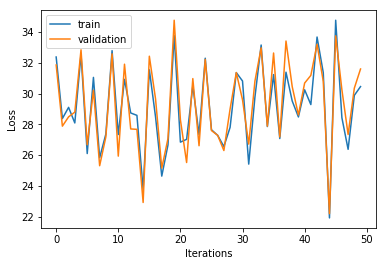

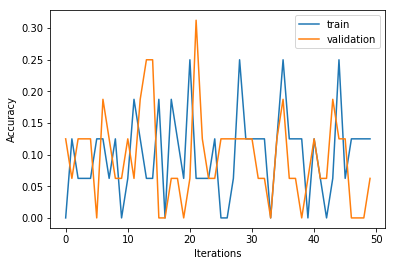

In [114]:
def iteration_lic(model, lsc, x, y, lr, training=True):
    out = model.forward(x)
    if training:
        grad_loss = lic.backward(out, y)
        model.backward(x, grad_loss)
        model.gradientStep(lr)
    else:
        return lic.forward(out,y),np.argmax(out,axis=1)==y
    
def training_lic(model, lsc, lr, indices):
    loss={}
    loss['train'],loss['validation']=[],[]
    
    acc={}
    acc['train'],acc['validation']=[],[]
    it=0
    for inds in zip(indices['train'],indices['validation']):
        it+=1
        for ind,train_val in zip(inds,['train','validation']):
            if train_val=='train':
                x,y = train_data[ind, :], train_labels[ind]
                iteration_lic(model,lsc,x,y,lr,True)
            else:
                x,y = val_data[ind, :], val_labels[ind]
            if it%10==0: # je n'affiche pas tous les points, sinon on ne voit plus rien
                loss_tmp,juste = iteration_lic(model,lsc,x,y,lr,False)
                loss[train_val].append(loss_tmp)
                acc[train_val].append(np.sum(juste)/len(juste))
    return loss, acc

model = MLP()
lic = L1Criterion()
lr = 0.013
indices = {}

indices['train'] = np.random.choice(np.arange(len(train_data)), size=(500,batch_size), replace=False)
indices['validation'] = np.random.choice(np.arange(len(val_data)),size=(500,batch_size),replace=False)

loss,acc=training(model,lic,lr,indices)

print("Cas de loss L1Criterion")
afficher(loss,"Loss")
afficher(acc,"Accuracy")

In [ ]:
class CrossEntropyCriterion(Module):
    """
    This implementation of the Cross-Entropy loss assumes that the data comes as a 2 dimensionnal array
    of size (batch_size,num_classes) and the labels as a vector of size (num_classes) 
    """
    def __init__(self, num_classes=10):
        super(CrossEntropyCriterion, self).__init__()
        self.num_classes=num_classes
        
    def sigmoid(x):
        return 1./(1+np.exp(-x))
    
    sigmoid = np.vectorize(sigmoid)
    
    def forward(self, x,labels):
        target=np.zeros([x.shape[0],self.num_classes])
        for i in range(x.shape[0]):
            target[i,labels[i]]=1
        self.output = np.sum(target*np.log(self.sigmoid(x)) \
                             + (1-target)*np.log(1-self.sigmoid(x)) ,axis=0)
        return np.sum(self.output)
    
    def backward(self, x, labels):
        target=np.zeros([x.shape[0],self.num_classes])
        
        for i in range(x.shape[0]):
            target[i,labels[i]]=1
    
        self.gradInput=self.sigmoid(x)-target

        return self.gradInput

Cas de loss CrossEntropyCriterion


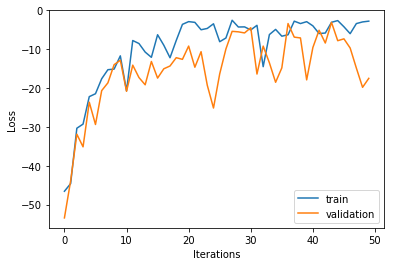

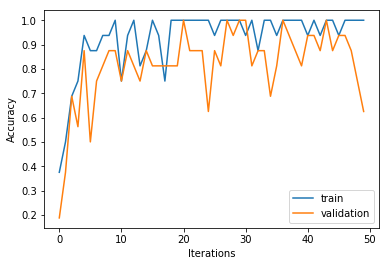

In [113]:
def iteration_lic(model, lsc, x, y, lr, training=True):
    out = model.forward(x)
    if training:
        grad_loss = lic.backward(out, y)
        model.backward(x, grad_loss)
        model.gradientStep(lr)
    else:
        return lic.forward(out,y),np.argmax(out,axis=1)==y
    
def training_lic(model, lsc, lr, indices):
    loss={}
    loss['train'],loss['validation']=[],[]
    
    acc={}
    acc['train'],acc['validation']=[],[]
    it=0
    for inds in zip(indices['train'],indices['validation']):
        it+=1
        for ind,train_val in zip(inds,['train','validation']):
            if train_val=='train':
                x,y = train_data[ind, :], train_labels[ind]
                iteration_lic(model,lsc,x,y,lr,True)
            else:
                x,y = val_data[ind, :], val_labels[ind]
            if it%10==0: # je n'affiche pas tous les points, sinon on ne voit plus rien
                loss_tmp,juste = iteration_lic(model,lsc,x,y,lr,False)
                loss[train_val].append(loss_tmp)
                acc[train_val].append(np.sum(juste)/len(juste))
    return loss, acc

model = MLP()
cec = CrossEntropyCriterion()
lr = 0.013
indices = {}

indices['train'] = np.random.choice(np.arange(len(train_data)), size=(500,batch_size), replace=False)
indices['validation'] = np.random.choice(np.arange(len(val_data)),size=(500,batch_size),replace=False)

loss,acc=training(model,cec,lr,indices)

print("Cas de loss CrossEntropyCriterion")
afficher(loss,"Loss")
afficher(acc,"Accuracy")

3/ Implement and test different non-linearities

In [102]:
class Sigmoid(Module):
    
    def __init__(self, bias=True):
        super(Sigmoid, self).__init__()
        
    def sigmoid(x):
        return 1./(1+np.exp(-x))
    
    sigmoid = np.vectorize(sigmoid)
        
    def forward(self, x):
        self.output = self.sigmoid(x)
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput = self.sigmoid(x)*(1 - self.sigmoid(x))*gradOutput
        return self.gradInput
    
class MLP_sigmoid(Module):

    def __init__(self, num_classes=10, hidden_layer_size = 64):
        super(MLP_sigmoid, self).__init__()
        self.fc1 = Linear(784, hidden_layer_size)
        self.sig1 = Sigmoid()
        self.fc2 = Linear(hidden_layer_size, 10)
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.sig1.forward(x)
        x = self.fc2.forward(x)
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc2.backward(self.sig1.output,gradient)
        gradient = self.sig1.backward(self.fc1.output,gradient)
        gradient = self.fc1.backward(x,gradient)
        return gradient
    
    def gradientStep(self,lr):
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)
        return True

On est sur le cas simple


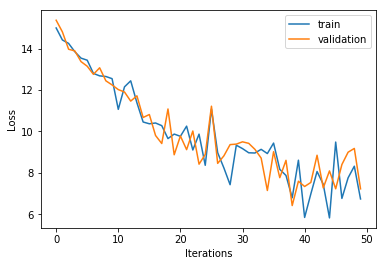

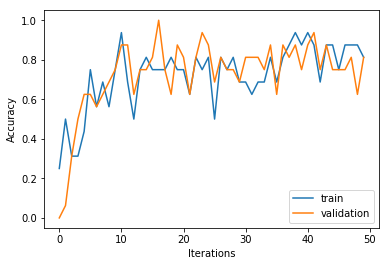

On est sur le cas sigmoid


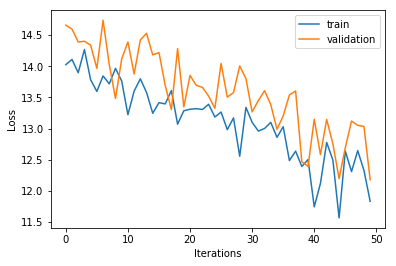

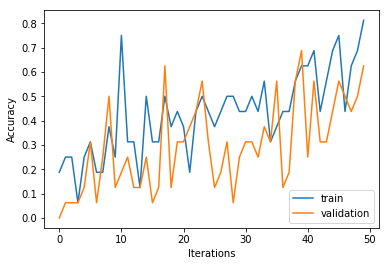

In [111]:
MLPs=[MLP(),MLP_sigmoid()]
MLPs_noms = ["simple", "sigmoid"]

lsc = LeastSquareCriterion()
lr = 0.001
batch_size=16
indices = {}

indices['train'] = np.random.choice(np.arange(len(train_data)), size=(500,batch_size), replace=False)
indices['validation'] = np.random.choice(np.arange(len(val_data)),size=(500,batch_size),replace=False)

for mlp,nom in zip(MLPs,MLPs_noms):
    model=mlp
    loss,acc=training(model,lsc,lr,indices)
    print("On est sur le cas",nom)
    afficher(loss,'Loss')
    afficher(acc,"Accuracy")

4/ (longer/harder) Implement and test layers that consider the 2D structure of the input data (max pooling, convolution)